# CS-401: Project Milestone 3

<span align="center"> 

# **Are women in movies clickbait feminism**?  

</span>


# Table of Content

- [Introduction](#introduction)
- [Pre-processing](#1-pre-processing)
- [Data Analysis](#2-data-analysis)
- [Conclusion](#3-conclusion)

# Introduction 

In [15]:
import warnings
warnings.filterwarnings('ignore')

import sys

sys.path.append("./preprocessing")
sys.path.append("./analysis")
sys.path.append("./nlp")

from scipy.stats import pearsonr
from wordcloud import WordCloud
from scipy import stats

import ast 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Our tools (see python files in preprocessing and analysis)
import loader
import cleaner
import merger
import roles 

# import roles
import visualizer as viz
import nlp_utils as nlputils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Pre-processing

In this section we perform loading and cleaning of our dataset

## 1.1. Loading and basic cleaning

### Part 1: CMU dataset

After loading these two datasets, we perfom some cleaning on the movies: 

- We convert string date to real datetime python object.
- We drop rows with no release date.

In [143]:
# Loading 
character_df, movie_df = loader.load_CMU_dataset()
summaries_df = loader.load_summaries()

# Basic cleaning
movie_df = cleaner.clean_movie_df(movie_df)

### Part 2: TMDB Dataset

Here we load the TMDB Dataset. We noticed that often gender are missing while names are available, We used wikipedia to recover gender based on names. For very few still unfound genders, we used the `GenderGuesser` Python package that allows to fill most of missing values for directors and procuders.

In [ ]:
# Loading
credits_df, meta_df = loader.load_tmdb_dataset()

# Basic cleaning (scraping takes times)
credits_df = cleaner.clean_credit_df(credits_df, meta_df)
meta_df = cleaner.clean_metadata_df(meta_df)

### Part 3: Bechdel Dataset 

In the cleaning process, we drop the column `id` which is not useful for our analysis. 

In [ ]:
# Loading
bechdel_df = loader.load_bechdel_dataset()

# Basic cleaning
bechdel_df = cleaner.clean_bechdel_df(bechdel_df)

## 1.2. Putting all together

This section merge all of our loaded and pre-processed dataset to make only one big `movies` dataframe that will be used through the entire analysis. 

### Part I: Merging dataset

In [ ]:
# Merge datasets
movies = merger.merge_with_char(movie_df, character_df)
movies = merger.merge_with_summaries(movies, summaries_df)
movies = merger.merge_with_metadata(movies, meta_df)
movies = merger.merge_with_credits(movies, credits_df)

# Put the actor_name column at the beginning since we have one row per actor name
movies = movies.reindex(
    columns=["actor_name"] + [col for col in movies.columns if col != "actor_name"]
)

display(movies.sample(5))

# It will be useful when we will analyze the effect of the bechdel score rating on
# the women's representation in movies
movies_with_bechdel = merger.merge_with_bechdel(movies, bechdel_df)

### Part 2: Add roles and categorize roles

Fetch all roles in the movies from tmdb and attempt to determine if they fit theses categories:
- Named character (John)
- Relationship with named character (John's wife)
- Unnamed character with function (Mechanic)
- Relationship with unnamed character with function (Mechanic's wife)
- Uncredited

In [ ]:
API_TMDB_TOKEN = "API_TMDB_TOKEN"

In [ ]:
movies = roles.get_roles(movies, API_TMDB_TOKEN)

In [16]:
# Alternatively:
# You can directly load full cleaned and merged data
movies = pd.read_pickle("./data/Processed/movies_cleaned.pkl")
movies_with_bechdel = pd.read_pickle("./data/Processed/movies_with_bechdel.pkl")

## 1.3. Advanced Cleaning and Pre-processing

This section is devoted to a more in-depth cleaning of our big dataset `movies`.

### Part 1. Outlier Removal 

In [15]:
movies.drop(columns=["wikiID"]).describe()

,movie_release_date,movie_bo_revenue,movie_runtime,year,actor_height_meters,actor_age_at_movie_release,vote_average
count,126290,7.191300e+04,124760.000000,126290.000000,61081.000000,97620.000000,126290.000000
mean,1991-09-26 05:39:04.945759744,8.389626e+07,106.590008,1991.207182,1.794253,38.528396,6.075294
min,1902-09-01 00:00:00,1.140800e+04,1.250000,1902.000000,0.610000,-81.000000,0.000000
25%,1983-12-12 00:00:00,7.724701e+06,92.000000,1983.000000,1.680000,28.000000,5.500000
50%,1999-05-28 00:00:00,2.807807e+07,102.000000,1999.000000,1.760000,37.000000,6.200000
75%,2006-12-20 00:00:00,9.075381e+07,116.000000,2006.000000,1.830000,48.000000,6.800000
max,2014-03-28 00:00:00,2.782275e+09,1003.000000,2014.000000,510.000000,96.000000,10.000000
std,NaN,1.567086e+08,26.240080,20.838320,4.238687,14.559805,1.147225


As one can see, there are outliers and dirty samples in the data: negative actor's ages, movies of 16h long, etc.
We will remove them in the next cell, outliers will be remove by quantile method (see [here](./preprocessing/cleaner.py#clean_remove_outlier))

In [16]:
movies = cleaner.clean_movies_ranges(movies)
movies = cleaner.clean_remove_outlier(
    movies, method="quantile", name="actor_height_meters"
)
movies = cleaner.clean_remove_outlier(movies, method="quantile", name="movie_runtime")

movies.drop(columns=["wikiID"]).describe()

,movie_release_date,movie_bo_revenue,movie_runtime,year,actor_height_meters,actor_age_at_movie_release,vote_average
count,57103,3.845700e+04,57103.000000,57103.000000,57103.000000,55424.000000,57103.000000
mean,1993-12-16 06:11:51.514281088,8.787368e+07,104.780915,1993.432184,1.756534,37.942895,6.018703
min,1914-03-08 00:00:00,1.263600e+04,57.000000,1914.000000,1.470000,0.000000,0.000000
25%,1988-04-22 00:00:00,9.493259e+06,93.000000,1988.000000,1.680000,28.000000,5.500000
50%,1999-11-17 00:00:00,3.238238e+07,102.000000,1999.000000,1.760000,36.000000,6.100000
75%,2006-09-15 00:00:00,9.841006e+07,115.000000,2006.000000,1.830000,46.000000,6.700000
max,2012-11-21 00:00:00,1.511758e+09,153.000000,2012.000000,2.050000,95.000000,10.000000
std,NaN,1.465971e+08,16.421360,18.293721,0.099834,13.892007,1.063204


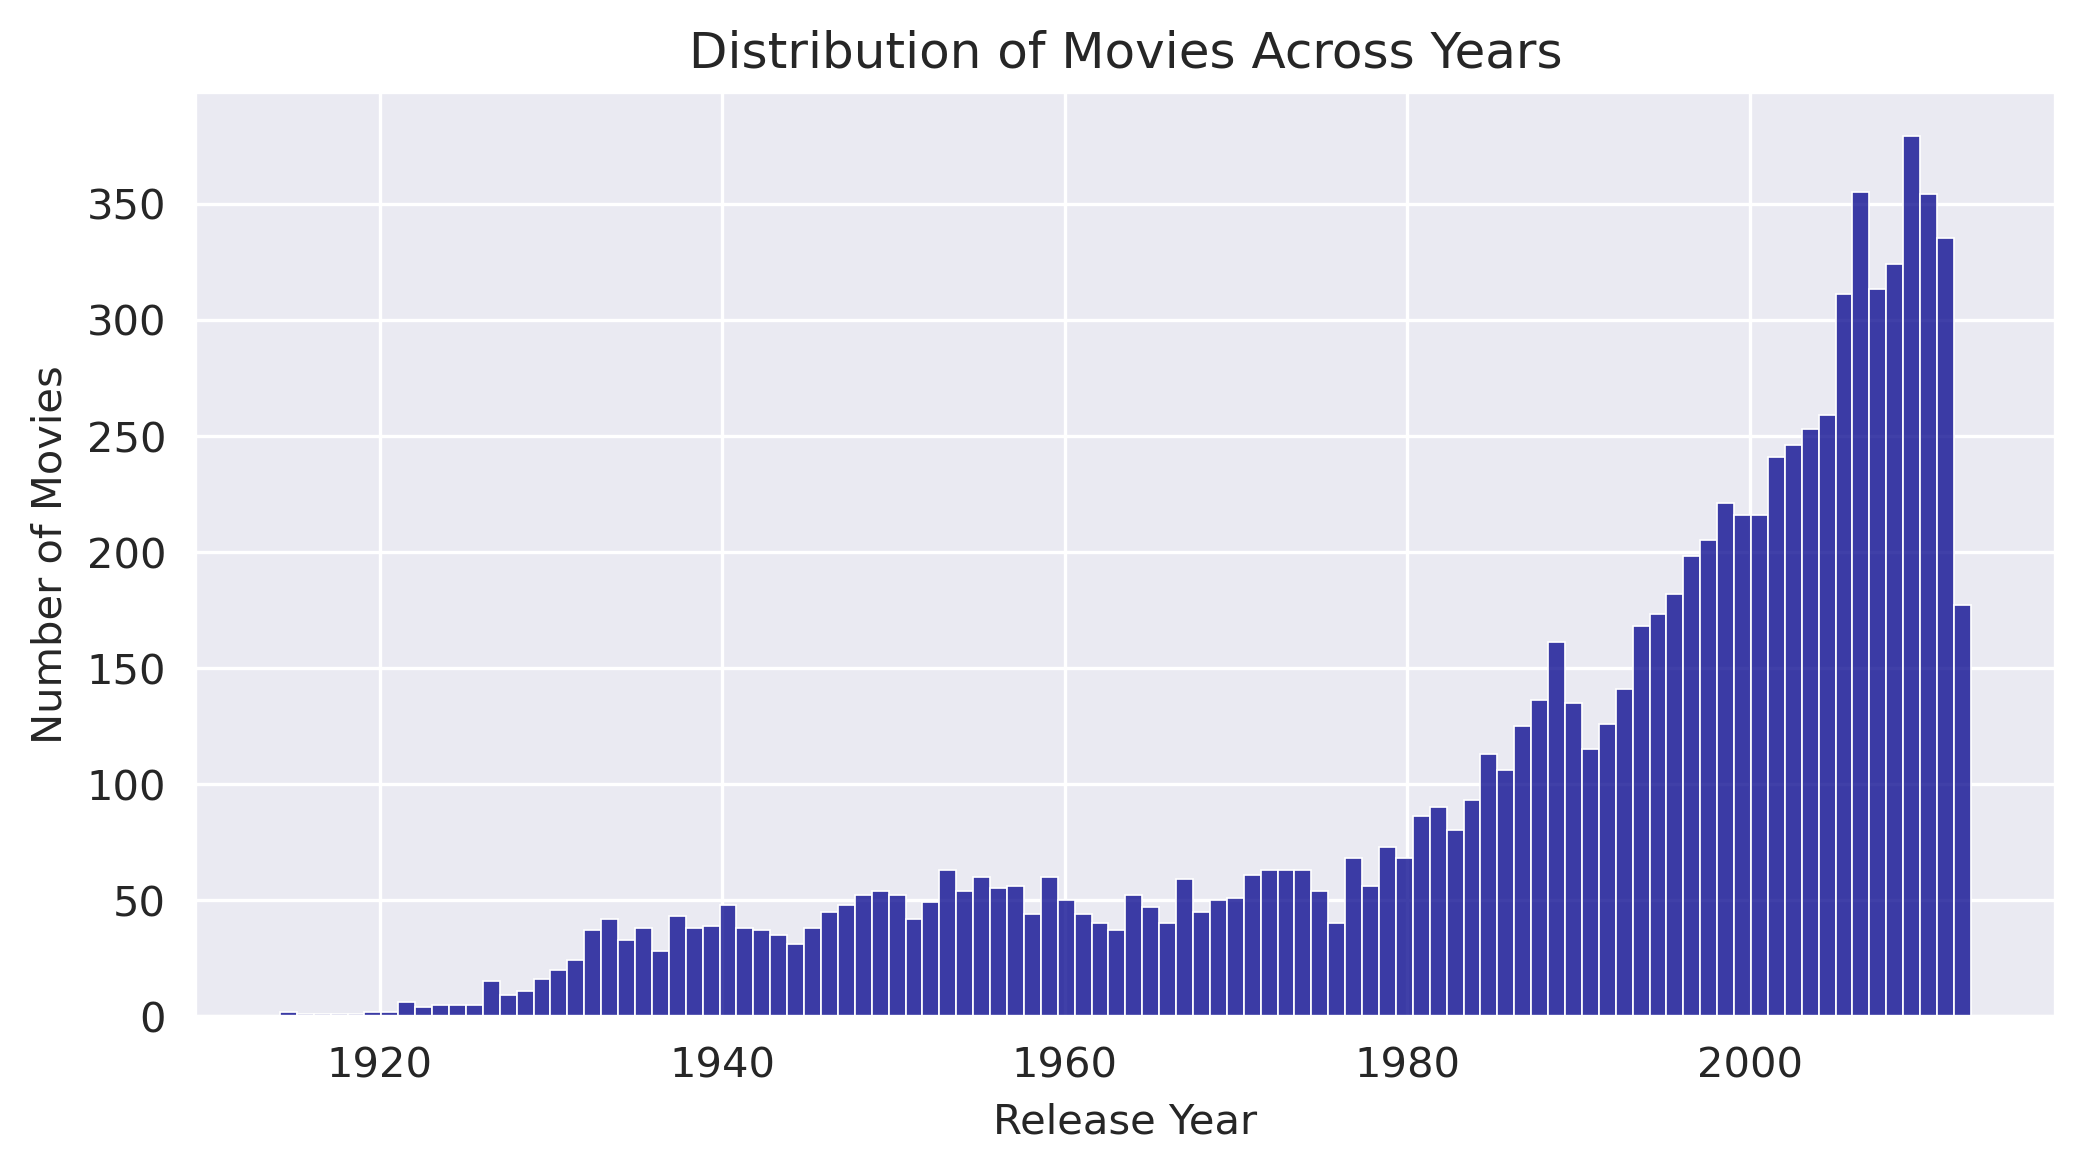

Total number of movies:  9146
Mean number of movies per year: 93


In [17]:
viz.visualize_year_distribution(movies)

Because some years only contain few movies, we will only use movies from 1980 to 2010 in future analysis of the evolution through the years.

In [18]:
YEAR_RANGE = [1980, 2010]

### Part 2. Handling missing values

Here, we interested in the proportion of missing values. 

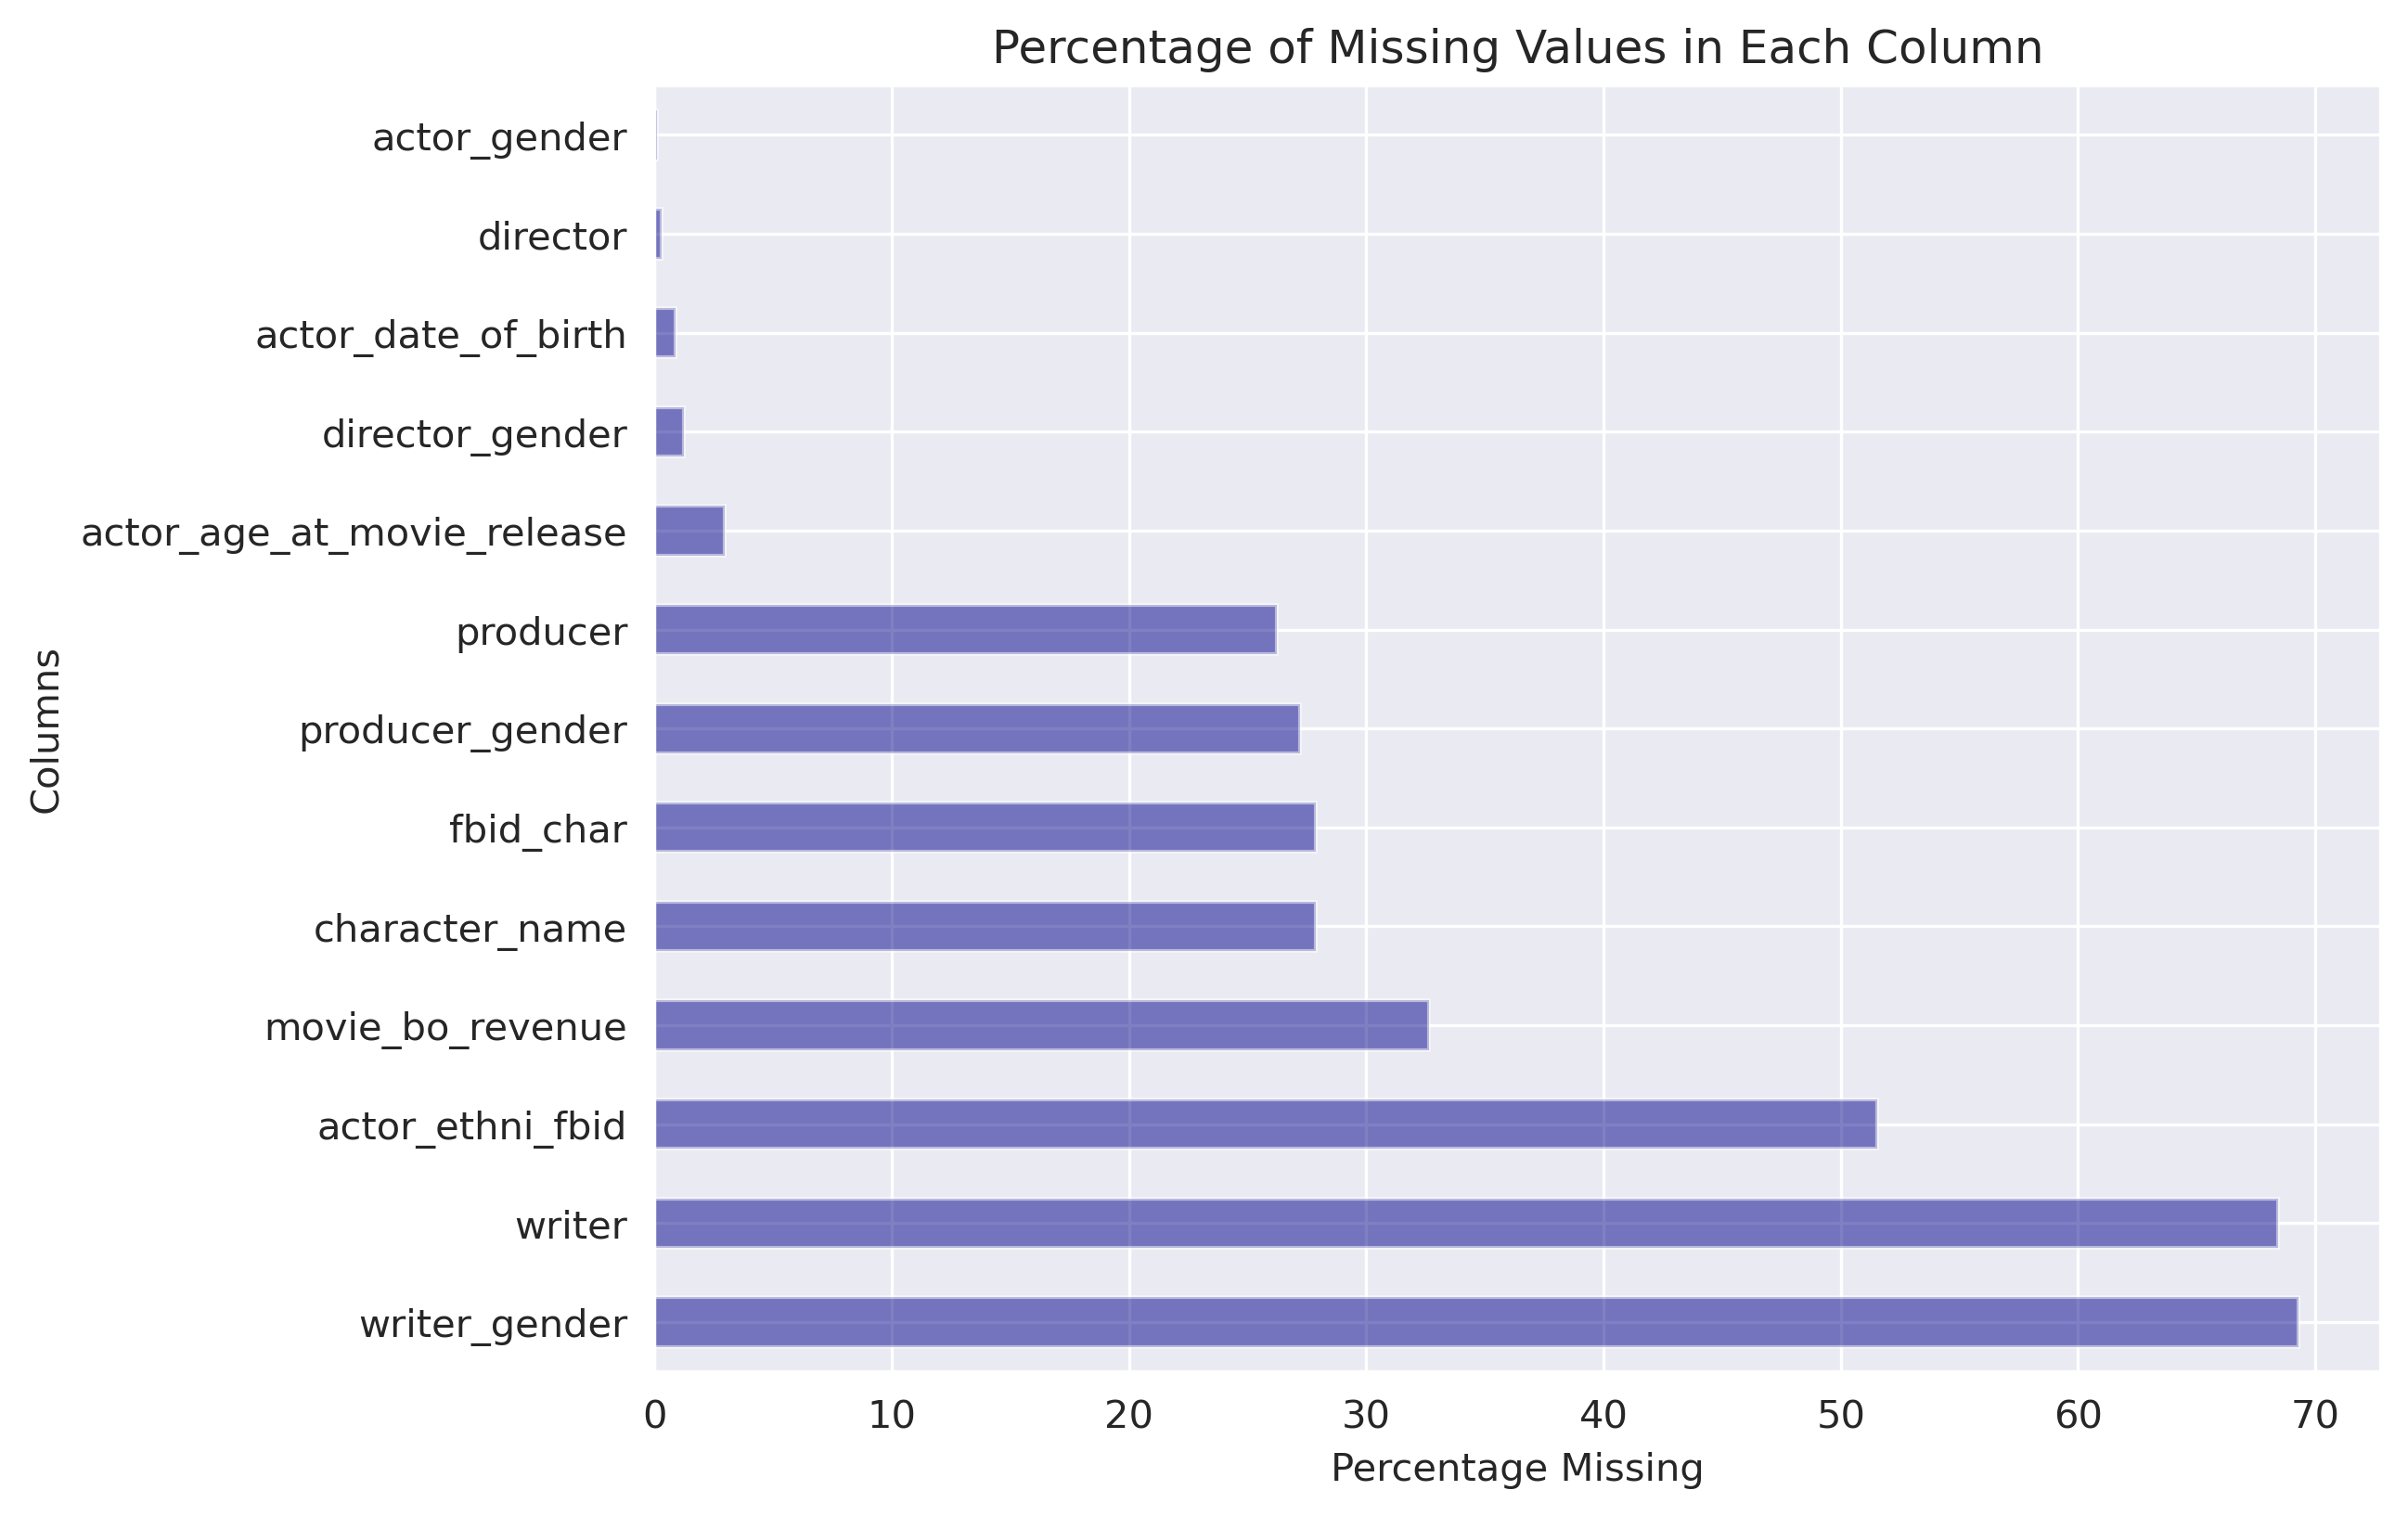

In [19]:
viz.visualize_missing_values(movies)

Based on the previous plot, it is evident that there are numerous missing values for the `writer` and `writer_gender` features. Given their limited usability due to this, it's necessary to remove them. Additionally, the `actor_ethni_fbid` feature, which would not have been utilized regardless, should also be dropped.

This correspond to dropping colums with more than 50% of missing values.

In [20]:
movies = cleaner.clean_missing_values_by_dropping(
    movies, to_drop=["writer", "writer_gender", "actor_ethni_fbid"]
)
display(movies.sample(2))

,actor_name,wikiID,freebaseID,movie_title,movie_release_date,movie_bo_revenue,movie_runtime,fbid_languages,fbid_countries,fbid_genres,...,summary,budget,popularity,vote_average,imdbid,id,director,director_gender,producer,producer_gender
93181,Penelope Ann Miller,997939,/m/03xx2x,Kindergarten Cop,1990-12-21,201957688.0,123.0,"[English Language, Spanish Language]",[United States of America],"[Thriller, Indie, Comedy Thriller, Action/Adve...",...,After years of pursuing drug dealer Cullen Cr...,15000000,3.67003,5.8,0099938,951,Ivan Reitman,M,Brian Grazer,M
73538,Dean Stockwell,2058218,/m/06j4km,The Legend of Billie Jean,1985-07-19,3099497.0,96.0,[English Language],[United States of America],"[Crime Fiction, Indie, Chase Movie, Coming of ...",...,"Billie Jean Davy , a Corpus Christi, Texas hig...",0,2.727843,6.6,0089470,15982,Mario Philip Azzopardi,M,NaN,NaN


# 2. Data Analysis 

## 2.1. Global Analysis 


### Part 1. Analysis of inequalities  

In this section, we will examine the distribution of women in various sectors of the movie industry. To begin, let's visualize the distribution of men and women across three roles: actors, film directors, and producers.

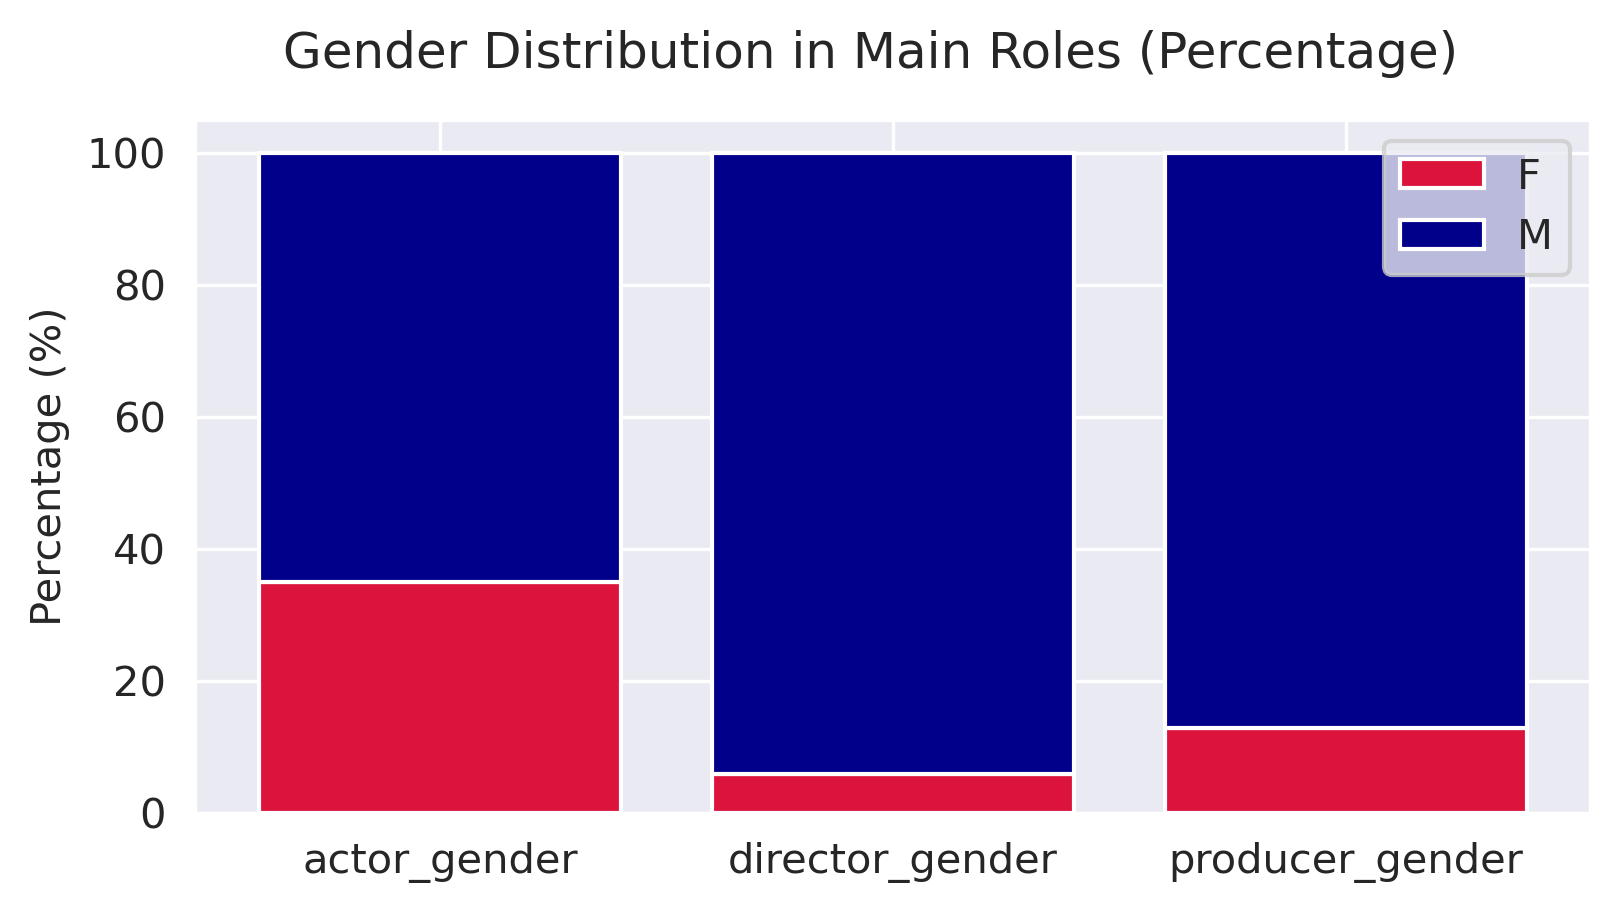

In [21]:
viz.visualize_gender_distribution_HTML(movies)
viz.visualize_gender_distribution(movies)

One can clearly see that women are underrepresented both in front of the camera and behind the scenes. Actually, they are much less represented behind the camera than in front of it. This is a first interesting observation.

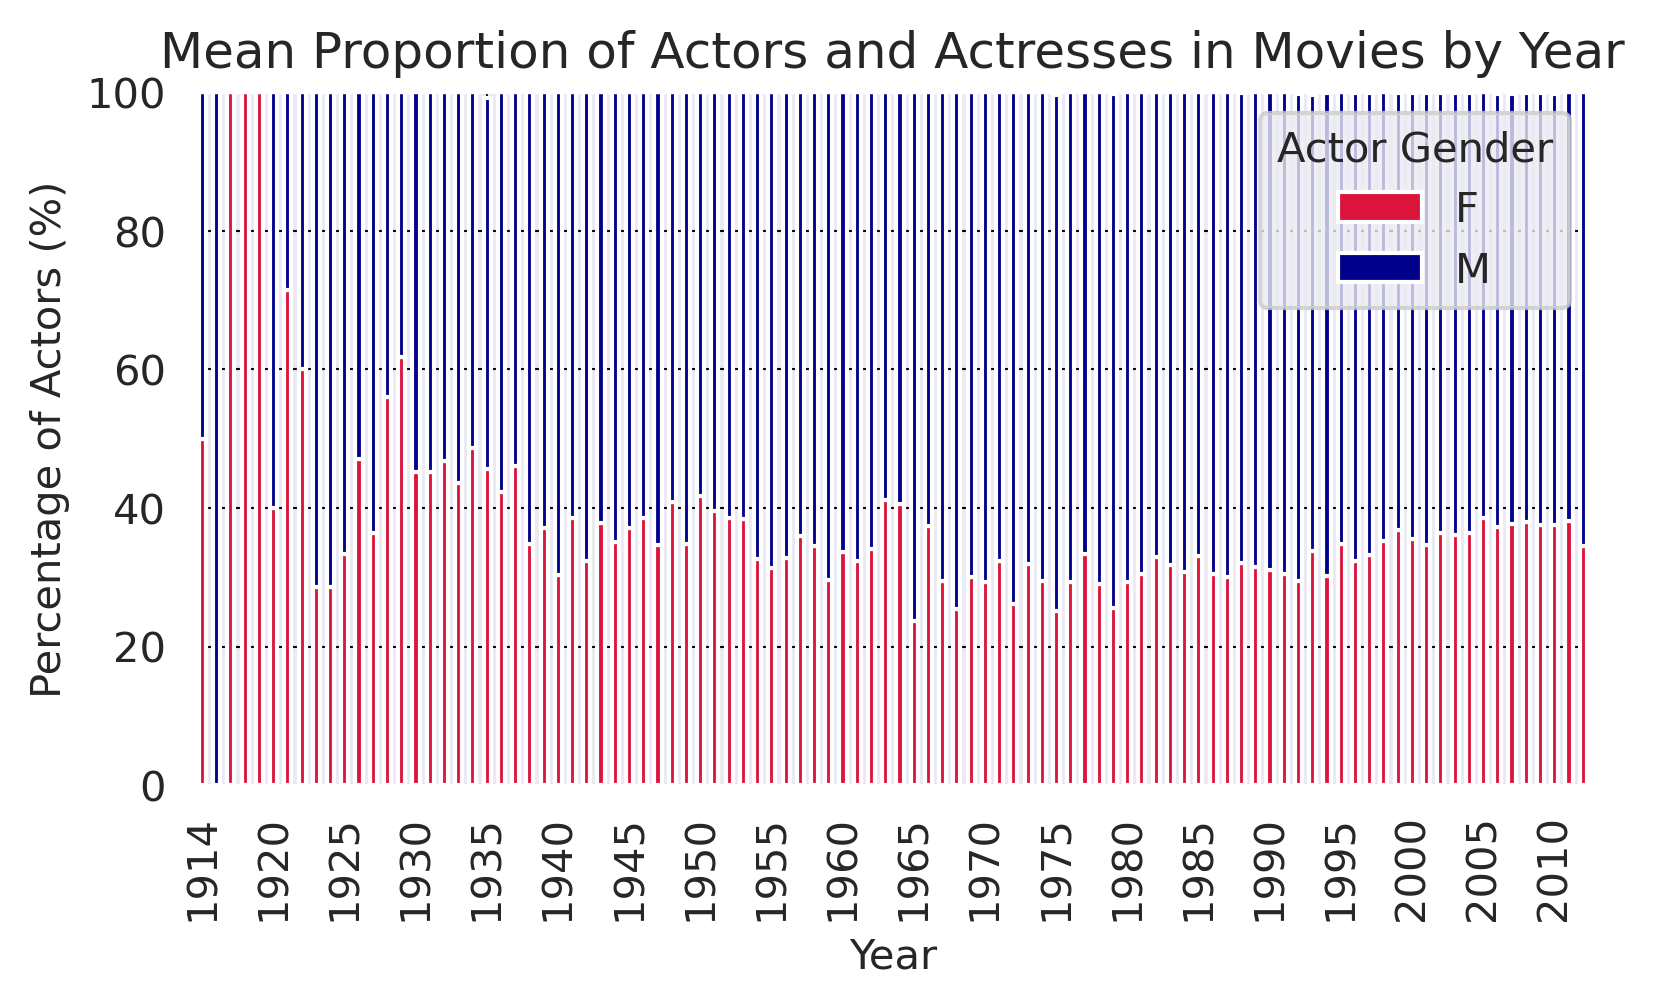

In [22]:
viz.visualize_actors_gender_proportion(movies)
viz.visualize_actors_gender_proportion_HTML(movies, year_range=YEAR_RANGE)

### Part 2. Analysis of correlation beetween proportion of female actrice and producer/director 's genders

In [17]:
from scipy import stats
from analysis.stats import ttest_gender_correlation
results = ttest_gender_correlation(movies)
for comparison, p_value in results.items():
    print(f"{comparison}: p-value = {p_value}")

No Female Director/Producer vs Female Producer Only: p-value = 0.00010346832836617623
No Female Director/Producer vs Female Director Only: p-value = 1.7623338717051237e-23
No Female Director/Producer vs Both Female Director and Producer: p-value = 2.658239922219762e-15


The results of your t-test analysis provide statistically significant evidence of differences in the proportion of female actors in movies based on the gender of the producer and director. Let's interpret these results:

No Female Director/Producer vs Female Producer Only: With a p-value of approximately 0.0001, this result indicates a statistically significant difference in the proportion of female actors between movies with no female directors/producers and those with female producers only. This suggests that having a female producer is associated with a higher proportion of female actors compared to movies without female leadership.

No Female Director/Producer vs Female Director Only: The p-value is around 1.76e-23, which is extremely low and indicates a highly significant difference in the proportion of female actors between movies with no female directors/producers and those with female directors only. This implies that the presence of a female director has a strong correlation with a higher proportion of female actors.

No Female Director/Producer vs Both Female Director and Producer: With a p-value of approximately 2.66e-15, this comparison also shows a highly significant difference. It suggests that movies with both a female director and a female producer have a notably higher proportion of female actors compared to movies without female directors and producers.

### Part 3. Analysis of stereotypes in gender representation

In this section, we want to explore roles given to women and see its stereotypes. First we will check the evolution of the age of the actors and actresses

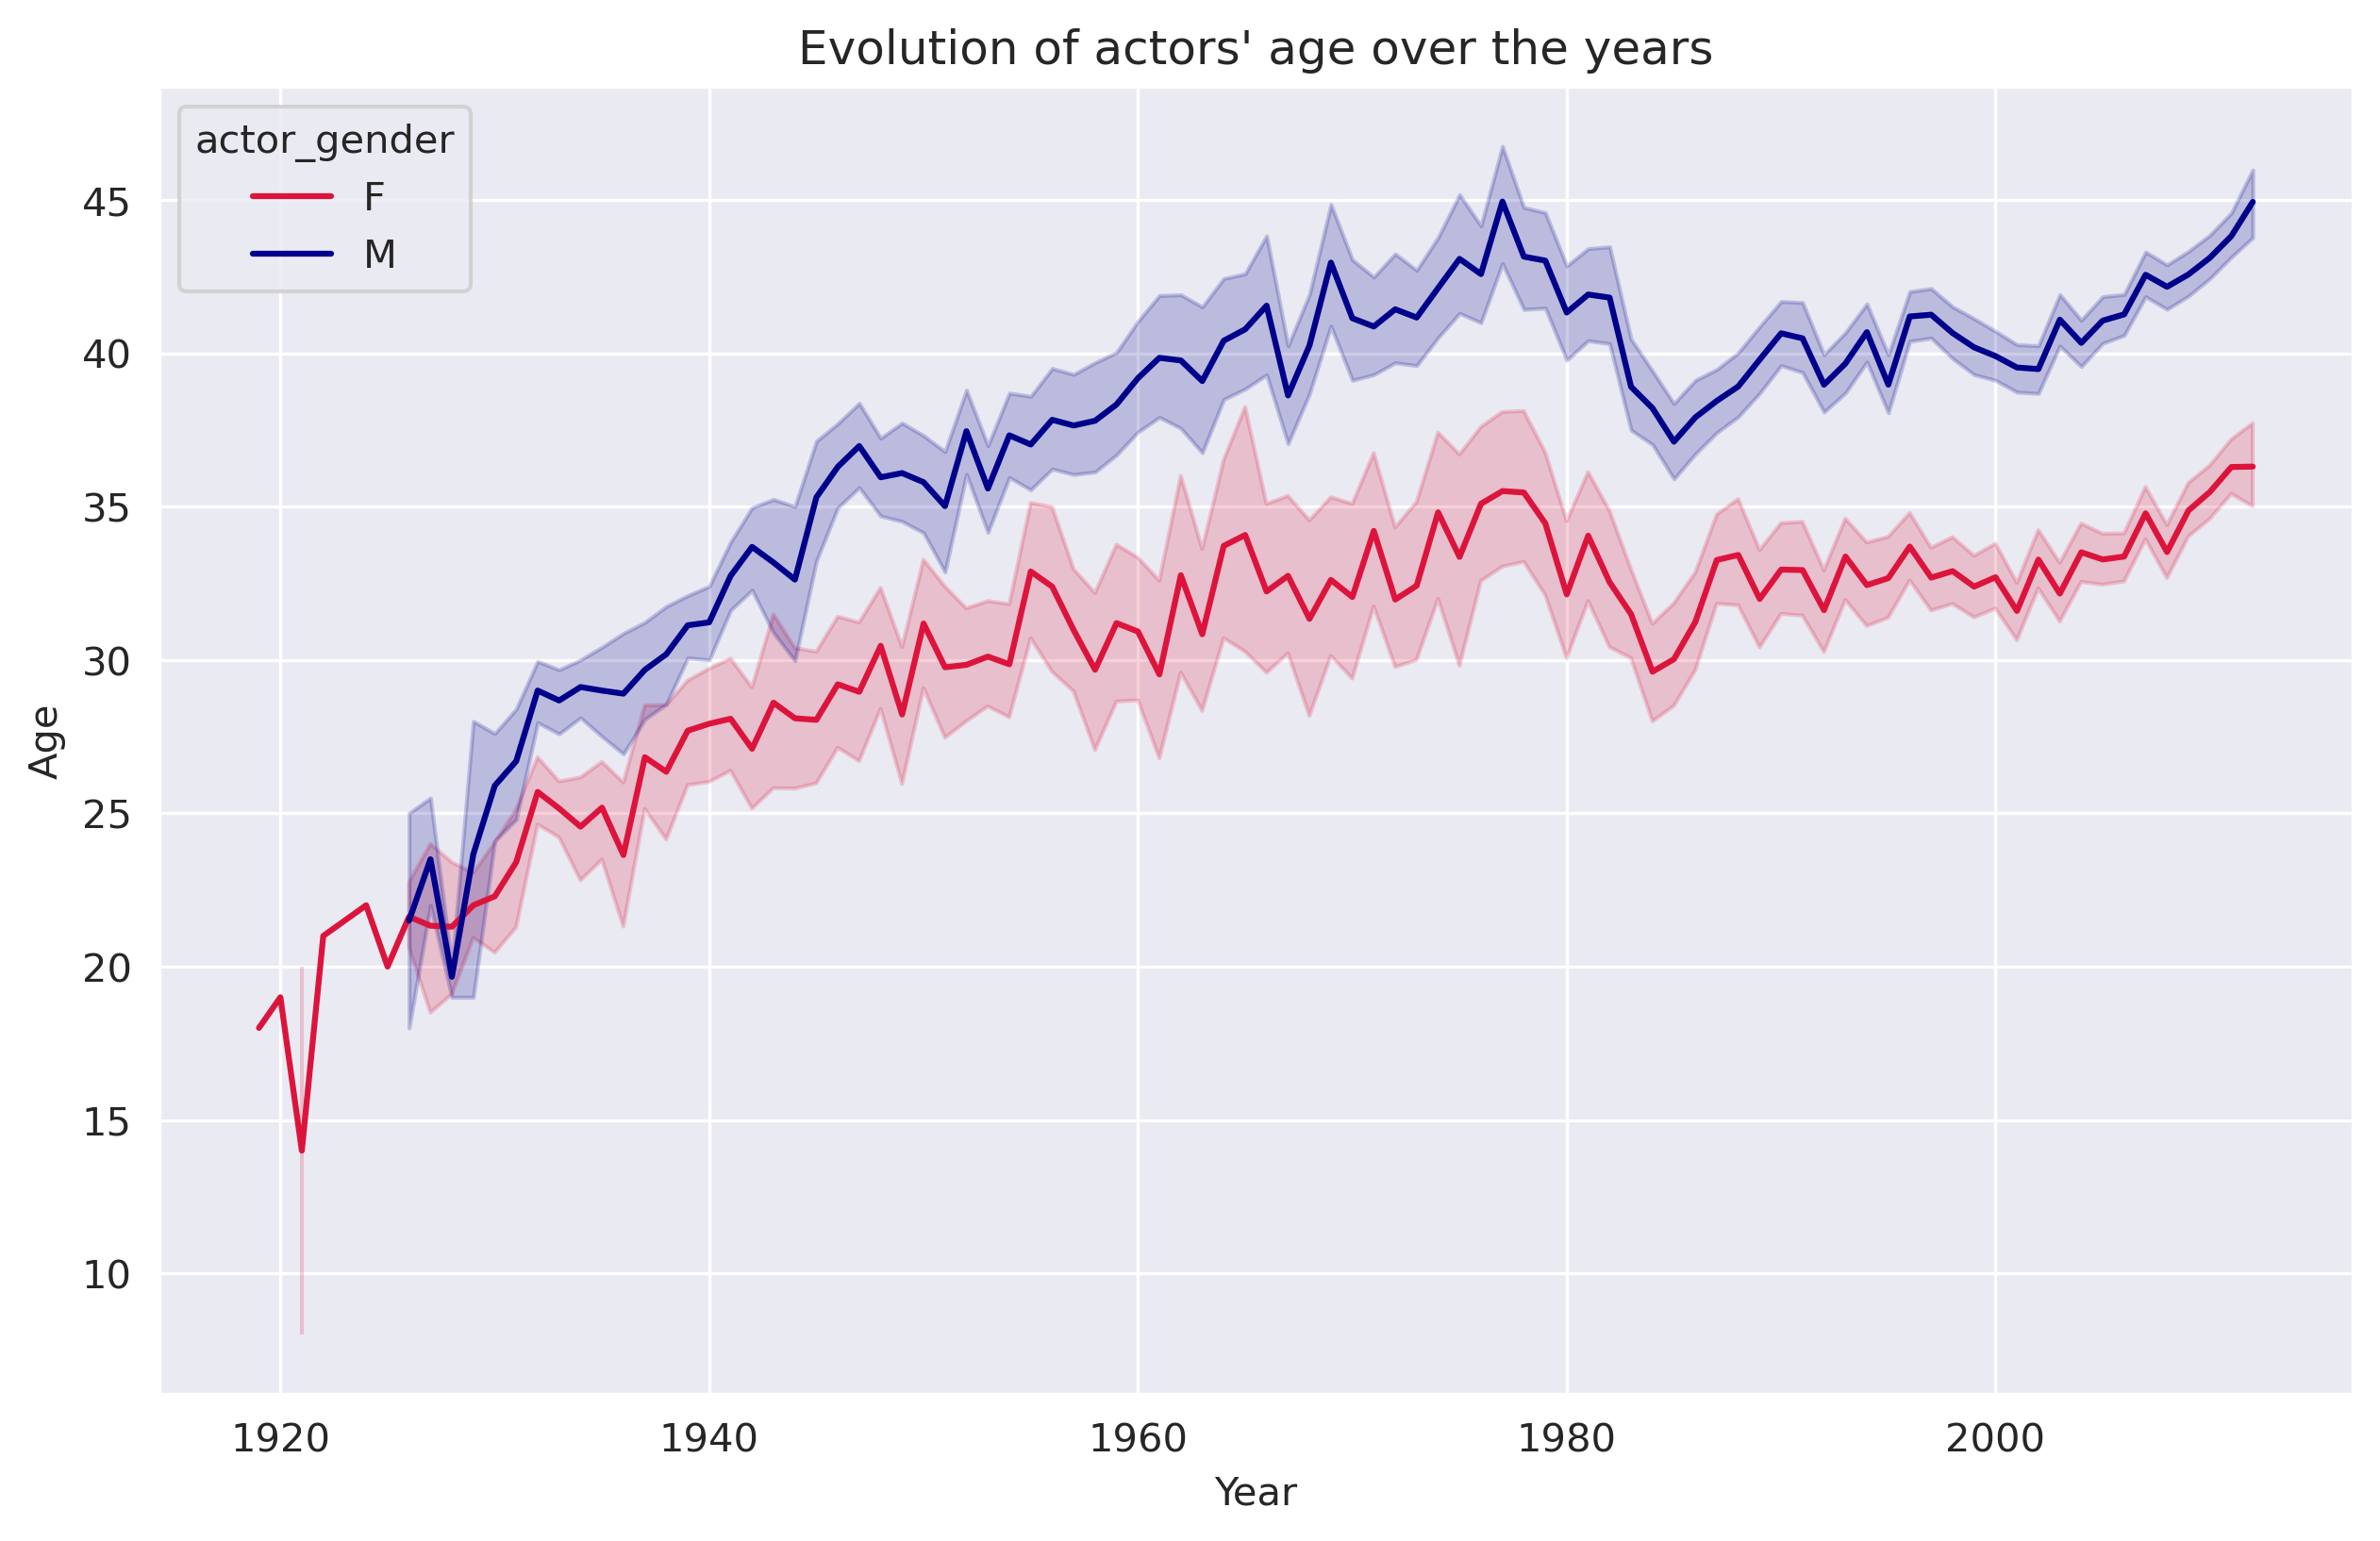

In [23]:
viz.visualize_age_evolution_HTML(movies, year_range=YEAR_RANGE)
viz.visualize_age_evolution(movies)

Across the years, the median age of actors and actresses does not seem to have changed. However, the difference between the median age of actors and actresses stayed more than stable: the difference is obvious and stays the same across the years. Indeed, the median age of actresses is almost 10 years lower than the median age of actors every year, which is quite a huge gap.

Then, we will analyze the contrast in the terms used for men and women using word clouds. It could reflect common gender stereotypes in storytelling and media, where men are often associated with power and action, while women are often portrayed in relation to beauty and emotional roles.

#### Analysis of roles played

Actors are credited in movies as several categories. \
Some roles have names in the scenario, some only have job duties. 

![Credited role categories](images/role_cat.png)
_Pictogram credit: [Dando](https://thenounproject.com/browse/collection-icon/characters-49091/?p=1)_

We translate theses categories to four level of importance, with more important characters having names and less charachter only being in a relationship with a nammed character or worse, with an unnamed character.

How does gender impact these different categories ?

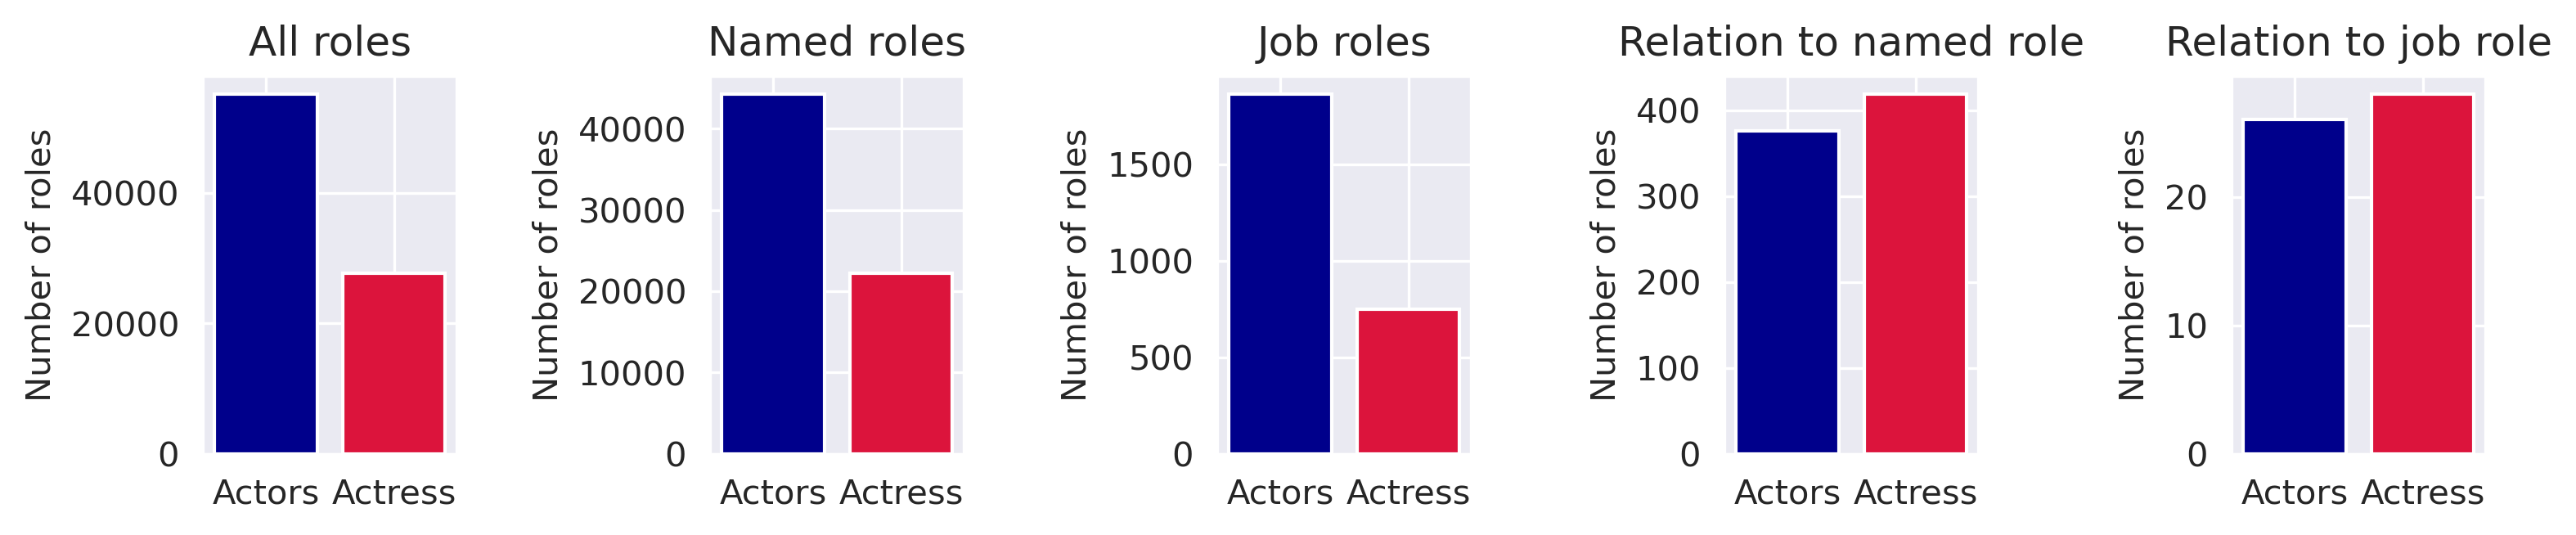

In [51]:
movies_with_roles_cat = pd.read_pickle("./data/Processed/movies_with_roles_cat.pkl")
viz.visualize_bar_plot_role_cat(movies_with_roles_cat, YEAR_RANGE)
viz.visualize_bar_plot_role_cat_HTML(movies_with_roles_cat, YEAR_RANGE)

##### Let's have a look at the roles credited as a job

We do see that overwelming majority of roles are played by actors for the two first categories. We however observe that it's not the case for roles that are of less importance, we see a higher number of actress. Let's look at what all of thse roles are !

What most common jobs do actors play ?

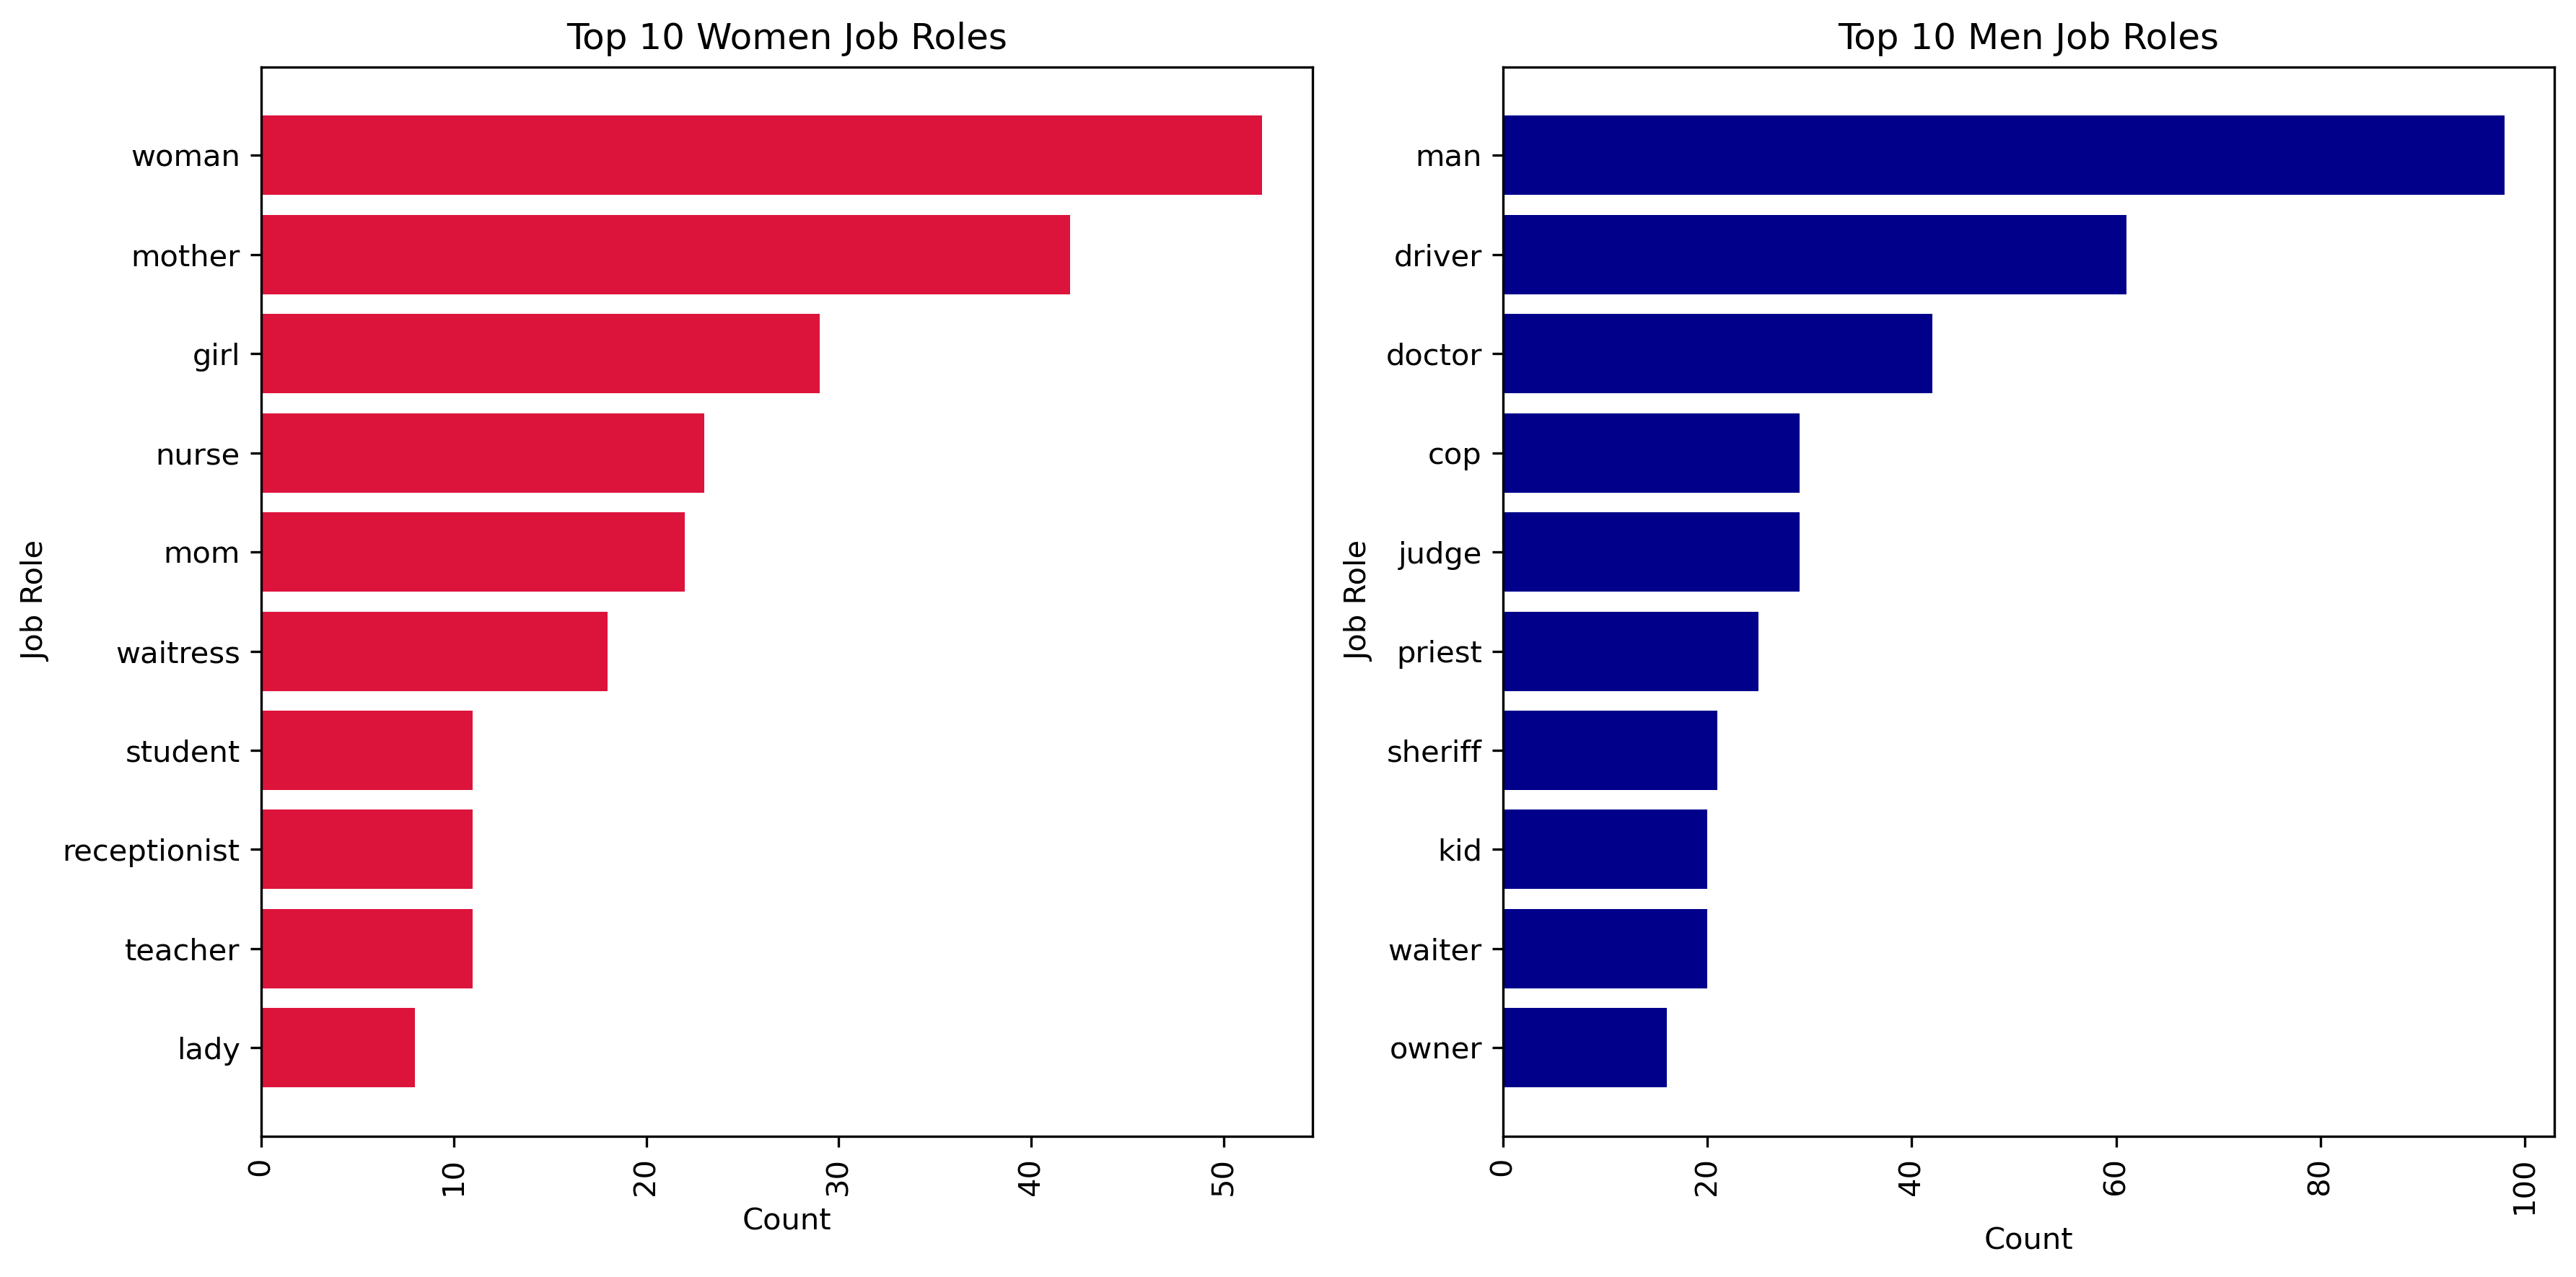

In [27]:
viz.visualize_bar_job_roles_bar(movies_with_roles_cat, YEAR_RANGE)
viz.visualize_bar_job_roles_bar_HTML(movies_with_roles_cat, YEAR_RANGE)


We find some roles which describe their position in the family. Theses roles were not classified by our NLP as supporting role to a named character as they may simply be label as "The grandmother" and not "Ted's grandmother".

We observe that for the roles that are not describing their position in the family, actress have roles such as nurse, waitress, receptionist... while men seem to have higher status roles such as doctors, cops/sheriff, owner, reporter, priest...

Let's take another look at the gender distribution in those roles. Are jobs with a perceived higher social status played by actors ?

We can compare the gender of the roles of doctors with nurses.

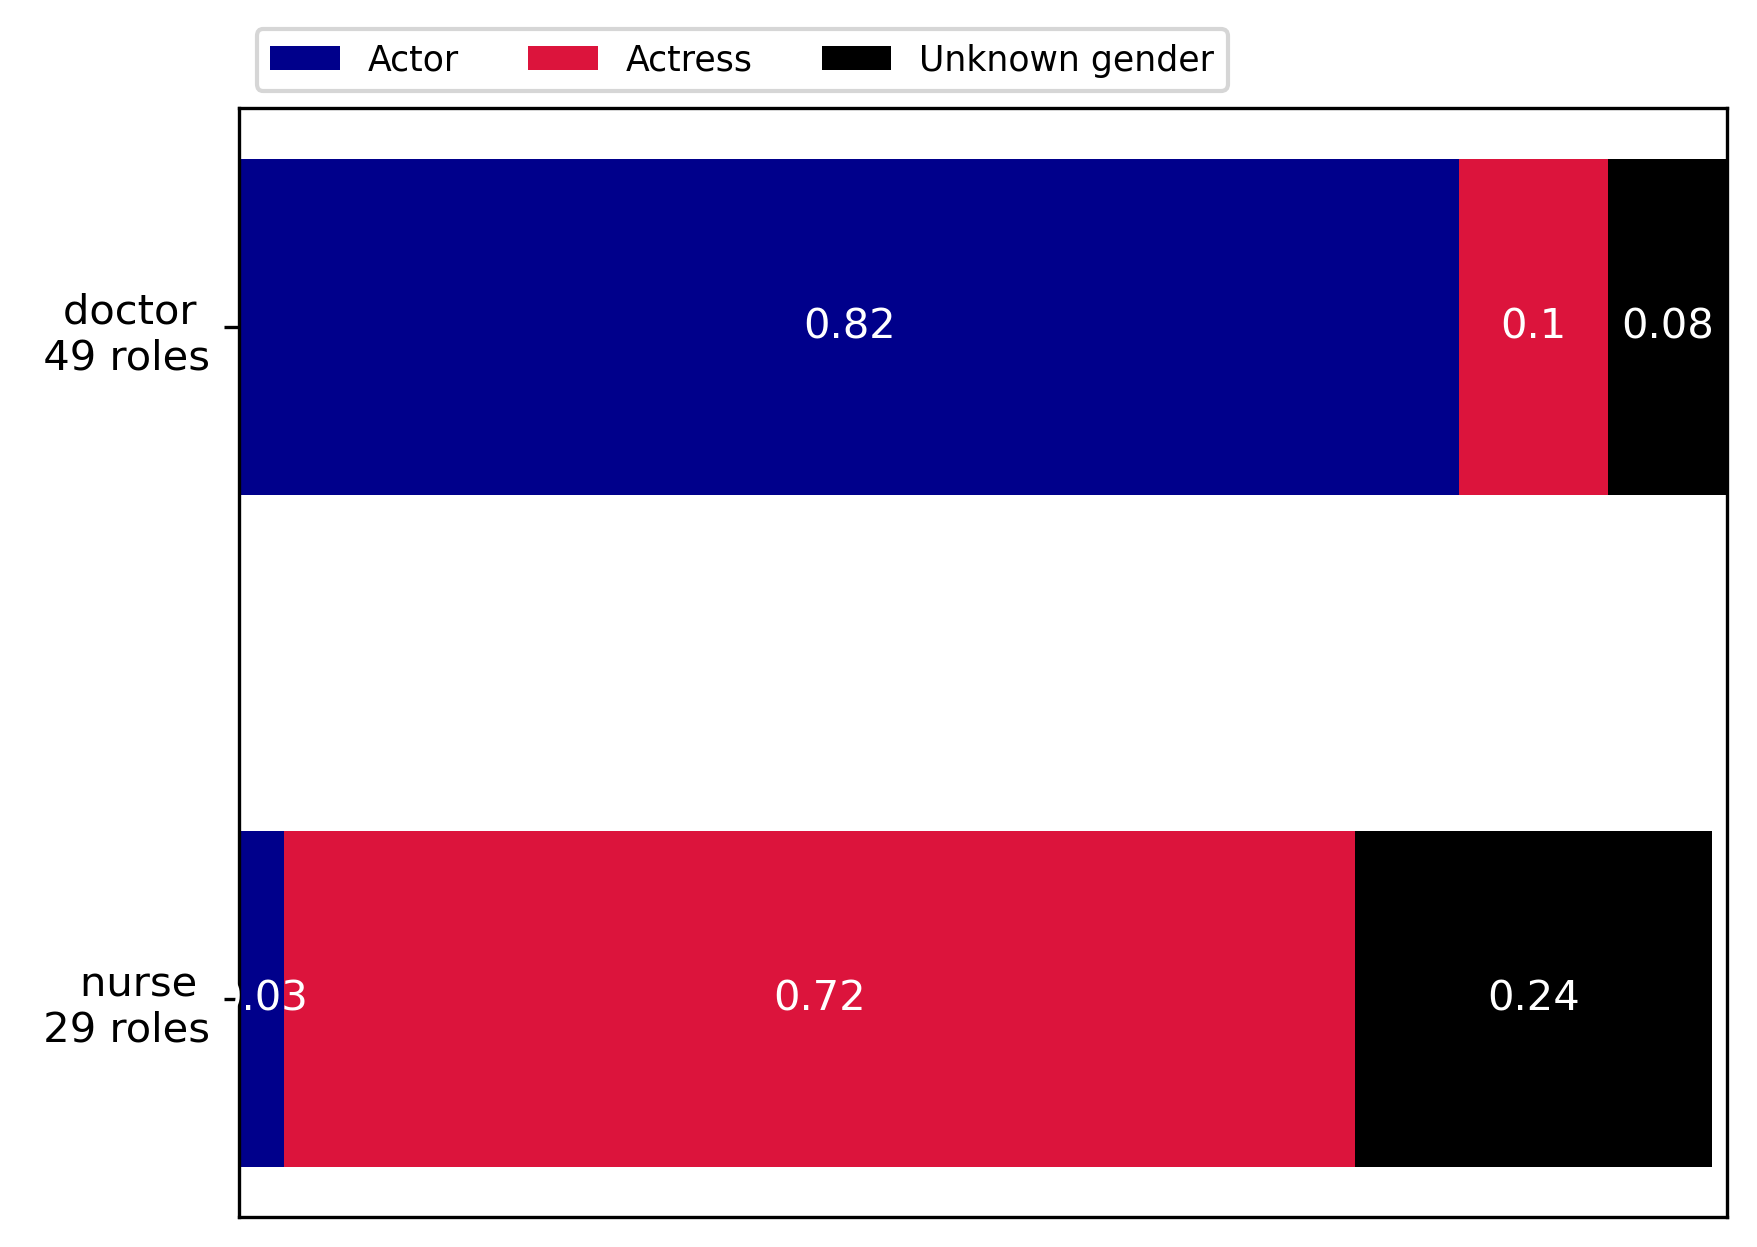

In [37]:
viz.job_comparison(movies_with_roles_cat,["doctor","nurse"], YEAR_RANGE)

So doctors are overwhelmingly played by men while nurse are mostly played by women. How does it compare to reality ?

Let's compare it to the 2008 U.S. Bureau of Labor Statistics. In the statistics, 68 \% of doctors are men, compared to 82\% of unnamed doctors character's in movies. While for nurse, 90\% of registered nurses are women, in movies it's 72\%.

_Citiation: Gender Diversity and Nurse-Physician Relationships. (2010). In AMA Journal of Ethics (Vol. 12, Issue 1, pp. 41–45). American Medical Association (AMA). https://doi.org/10.1001/virtualmentor.2010.12.1.msoc1-1001_


So, while not a perfectly identical to the gender gap in our society, we find a heavy bias in how the roles are casted. Let's check if this is evolving through time:

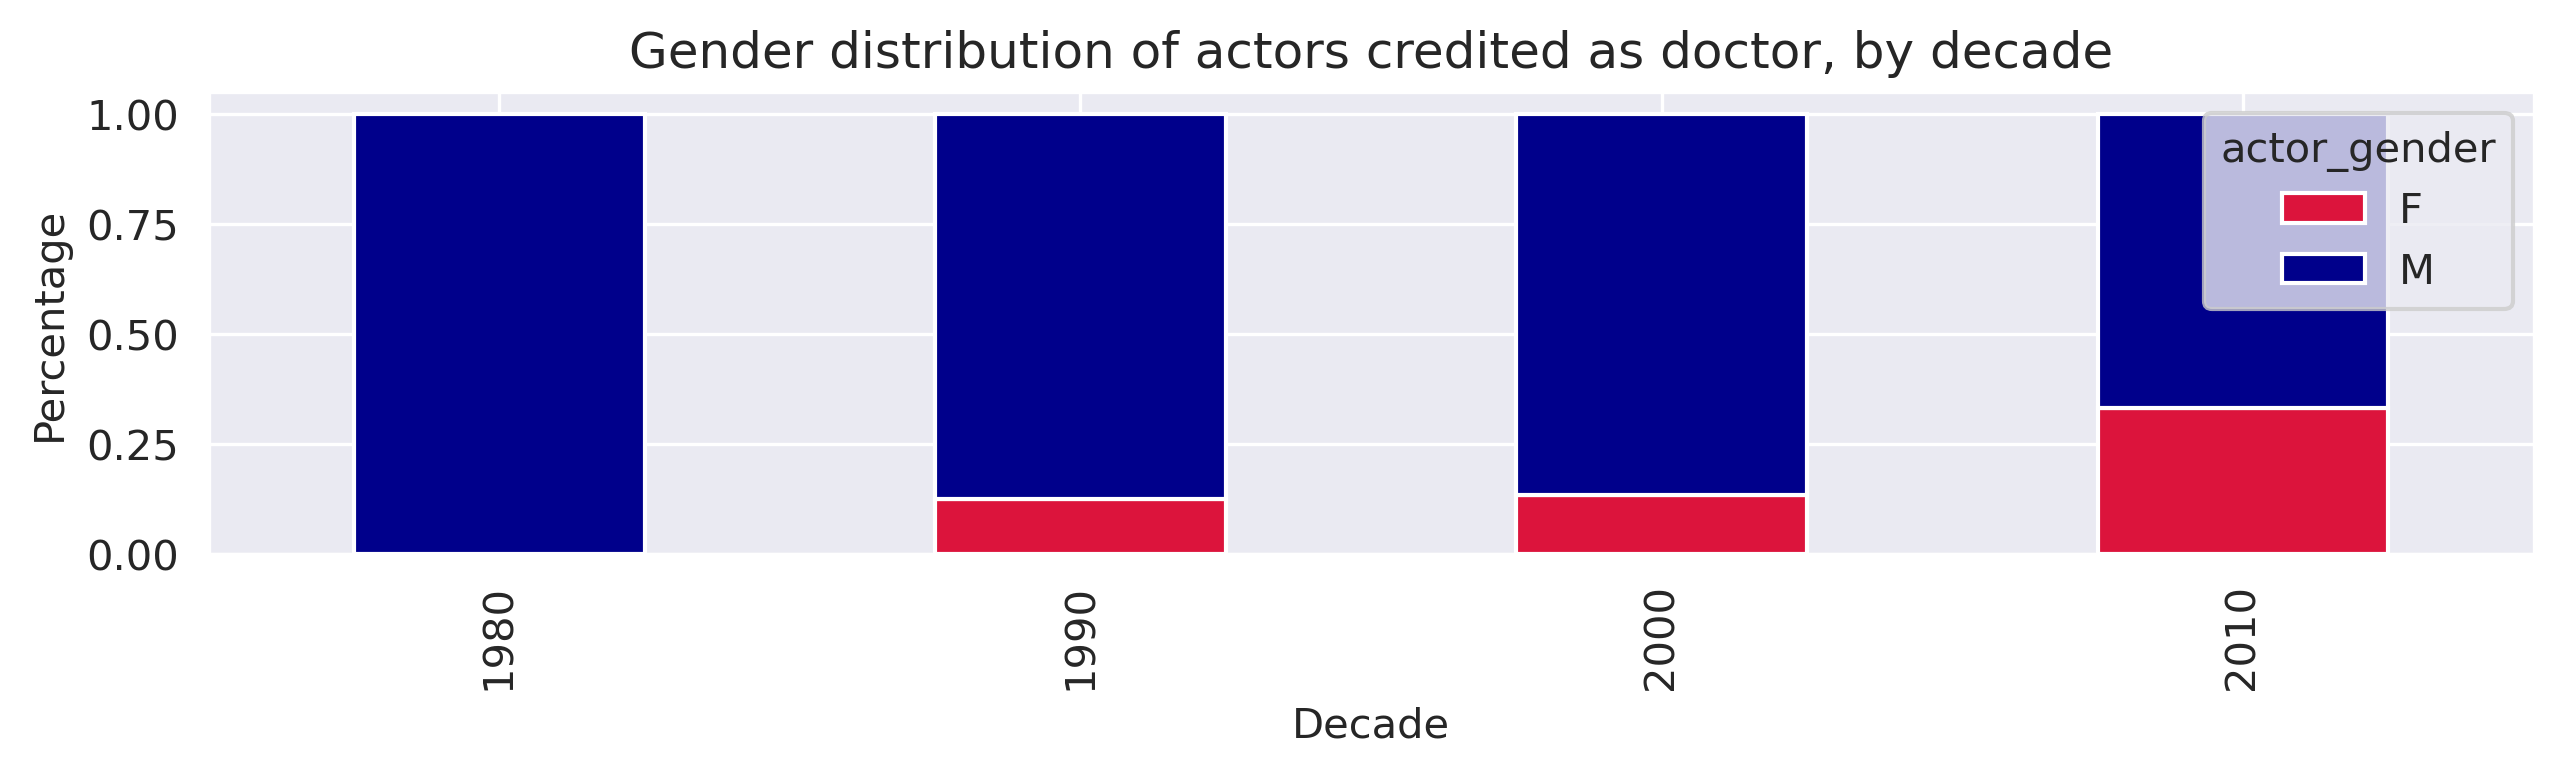

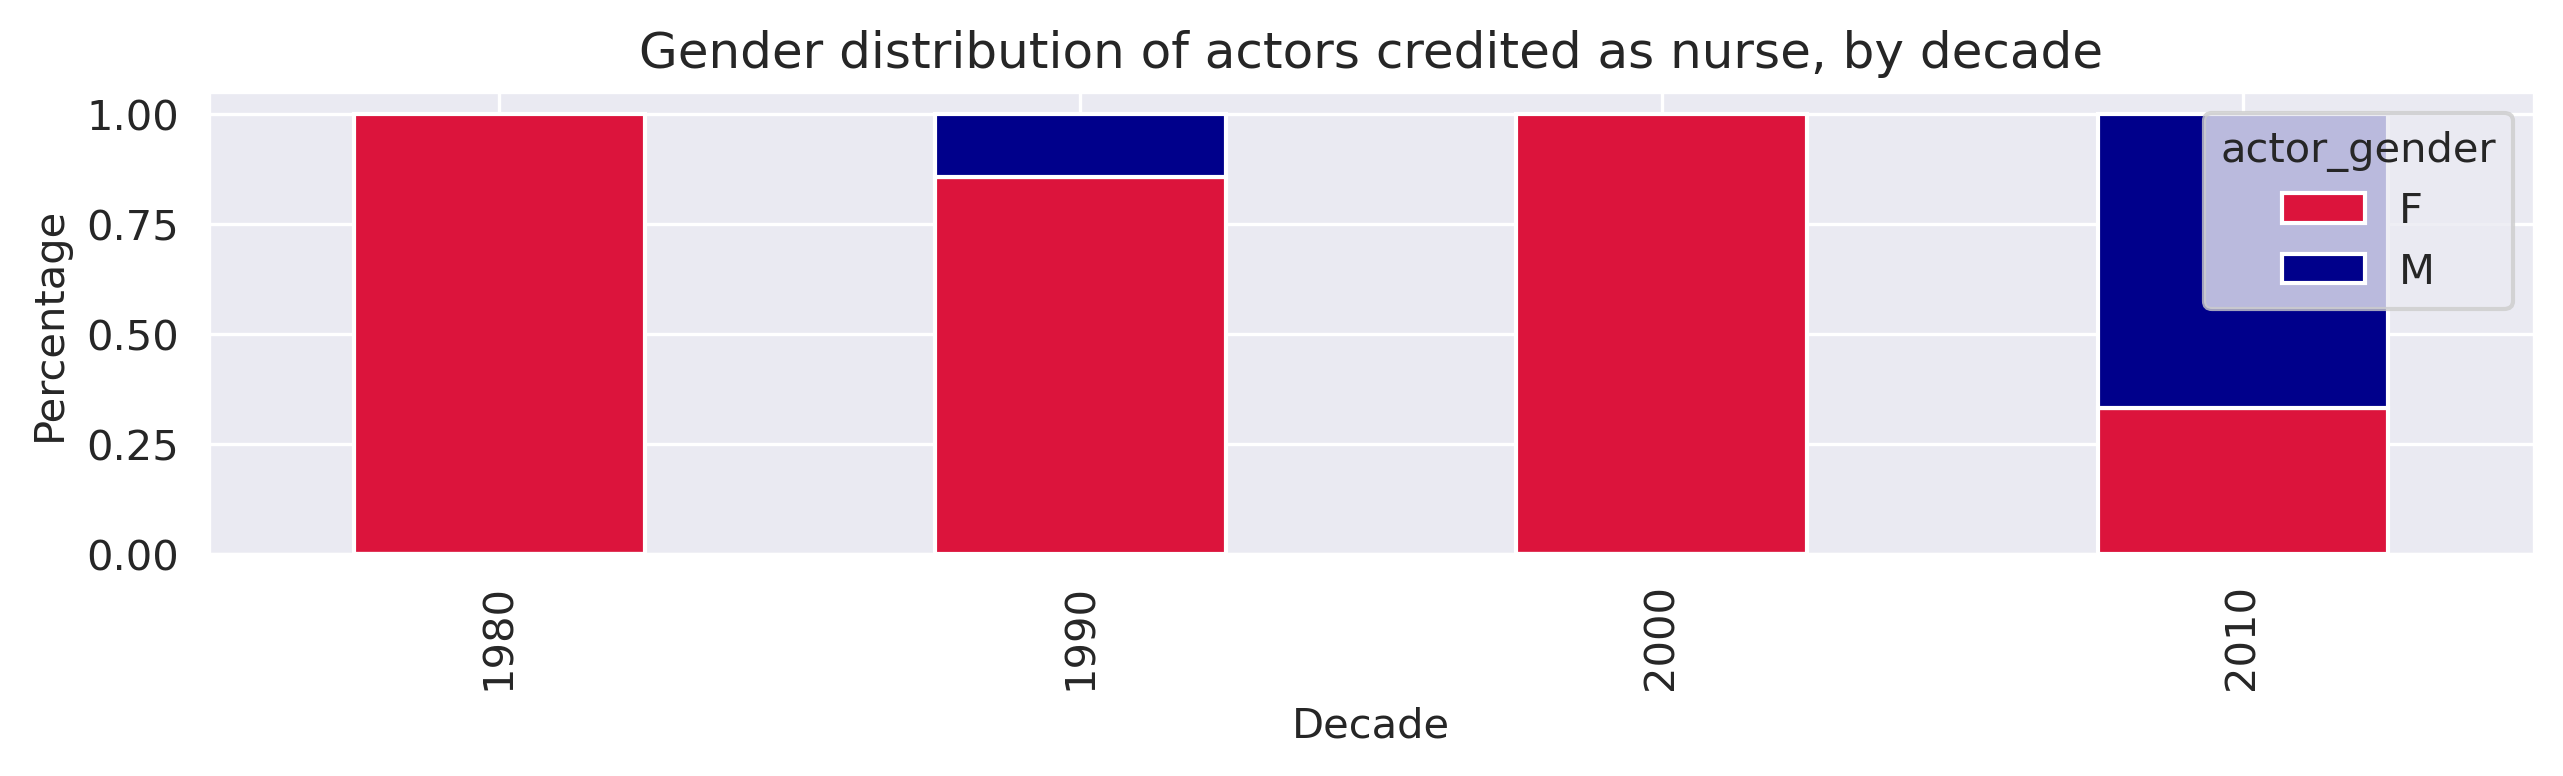

In [62]:
viz.role_job_barplot_history(movies_with_roles_cat,"doctor", YEAR_RANGE)
viz.role_job_barplot_history_HTML(movies_with_roles_cat,"doctor", YEAR_RANGE)
viz.role_job_barplot_history(movies_with_roles_cat,"nurse", YEAR_RANGE)
viz.role_job_barplot_history_HTML(movies_with_roles_cat,"nurse", YEAR_RANGE)

While we do see that movies in 2010s seem to completely differ from the other year, this first look at the data seems to indicate less bias in recent years.\
Let's check another professions:

In [57]:
jobs = ["doctor", "cop", "driver", "judge", "professor", "prosecutor", "owner", ["waiter", "waitress"], "reporter", "teacher", "receptionist", "nurse"]
viz.job_comparison(movies_with_roles_cat, jobs, YEAR_RANGE)

For a few of the jobs listed in the most common roles, we find that most of them are heavily gendered.\
For example: looking at the gender distribution of teachers and professors. One title: professor is linked to higher education and seems to be a role heavily played by men, while the other: teacher is played by both actor and actresses.

As we have a small number of roles played for each job, we will attempt to have a look at the bigger picture. \
Let's agregate some data using a useful metric.\
If women play roles of jobs with a lower social status, what does their fictional average salary would look like ?\
We used the data from the May 2022 National Occupational Employment and Wage Estimates to estimate the average salary of the jobs played by actors and actresses.

_Citation: U.S. BUREAU OF LABOR STATISTICS. 2008. “May 2018 National Occupational Employment and Wage Estimates.” Bls.gov. Retrieved (https://www.bls.gov/oes/current/oes_nat.htm)._

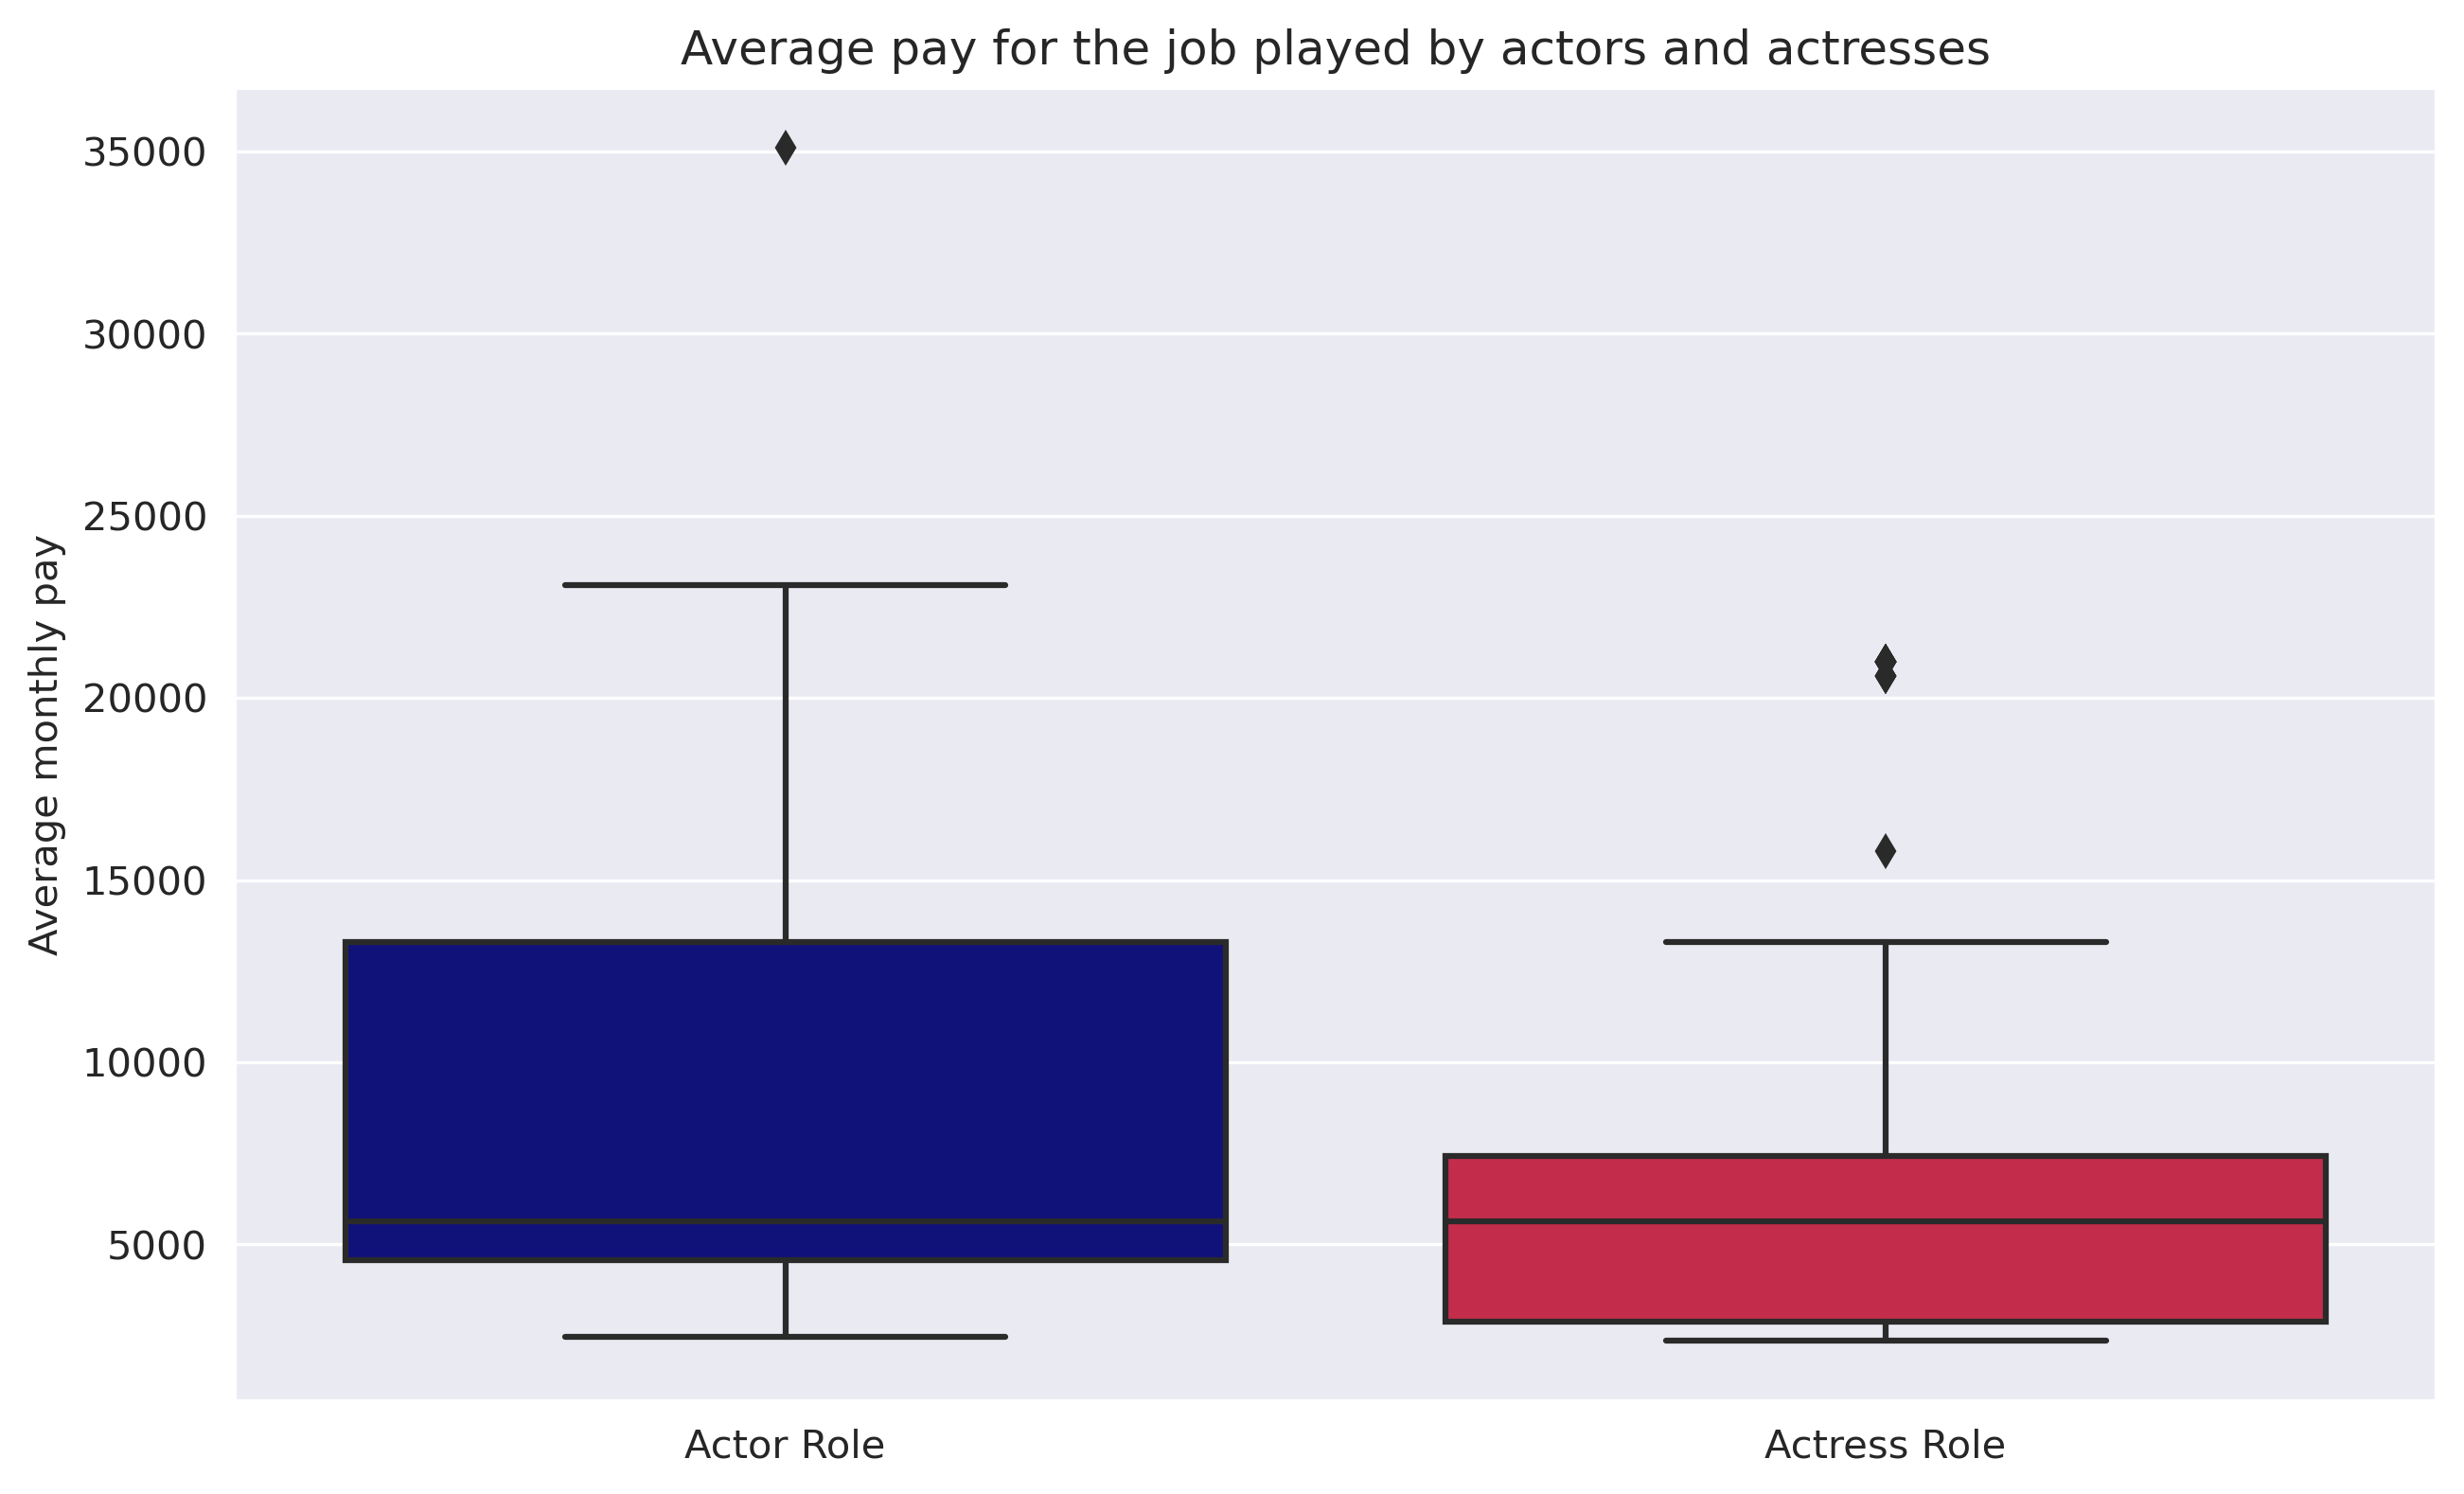

In [64]:
viz.visualize_box_plot_role_avg_pay(movies_with_roles_cat, YEAR_RANGE)
viz.visualize_box_plot_role_avg_pay_HTML(movies_with_roles_cat, YEAR_RANGE)


We observe an almost identical median ! But we do observe some differences, as we can see that low-wages jobs are mostly acted by women while actors are casted to high paying jobs.
We also very find a glass ceiling as the maximum salary for jobs played by actress corresponds to the upper quartile of the men's job.


##### We will now take a peak at the 10 most played supporting role, credited in a relationship to a named character.

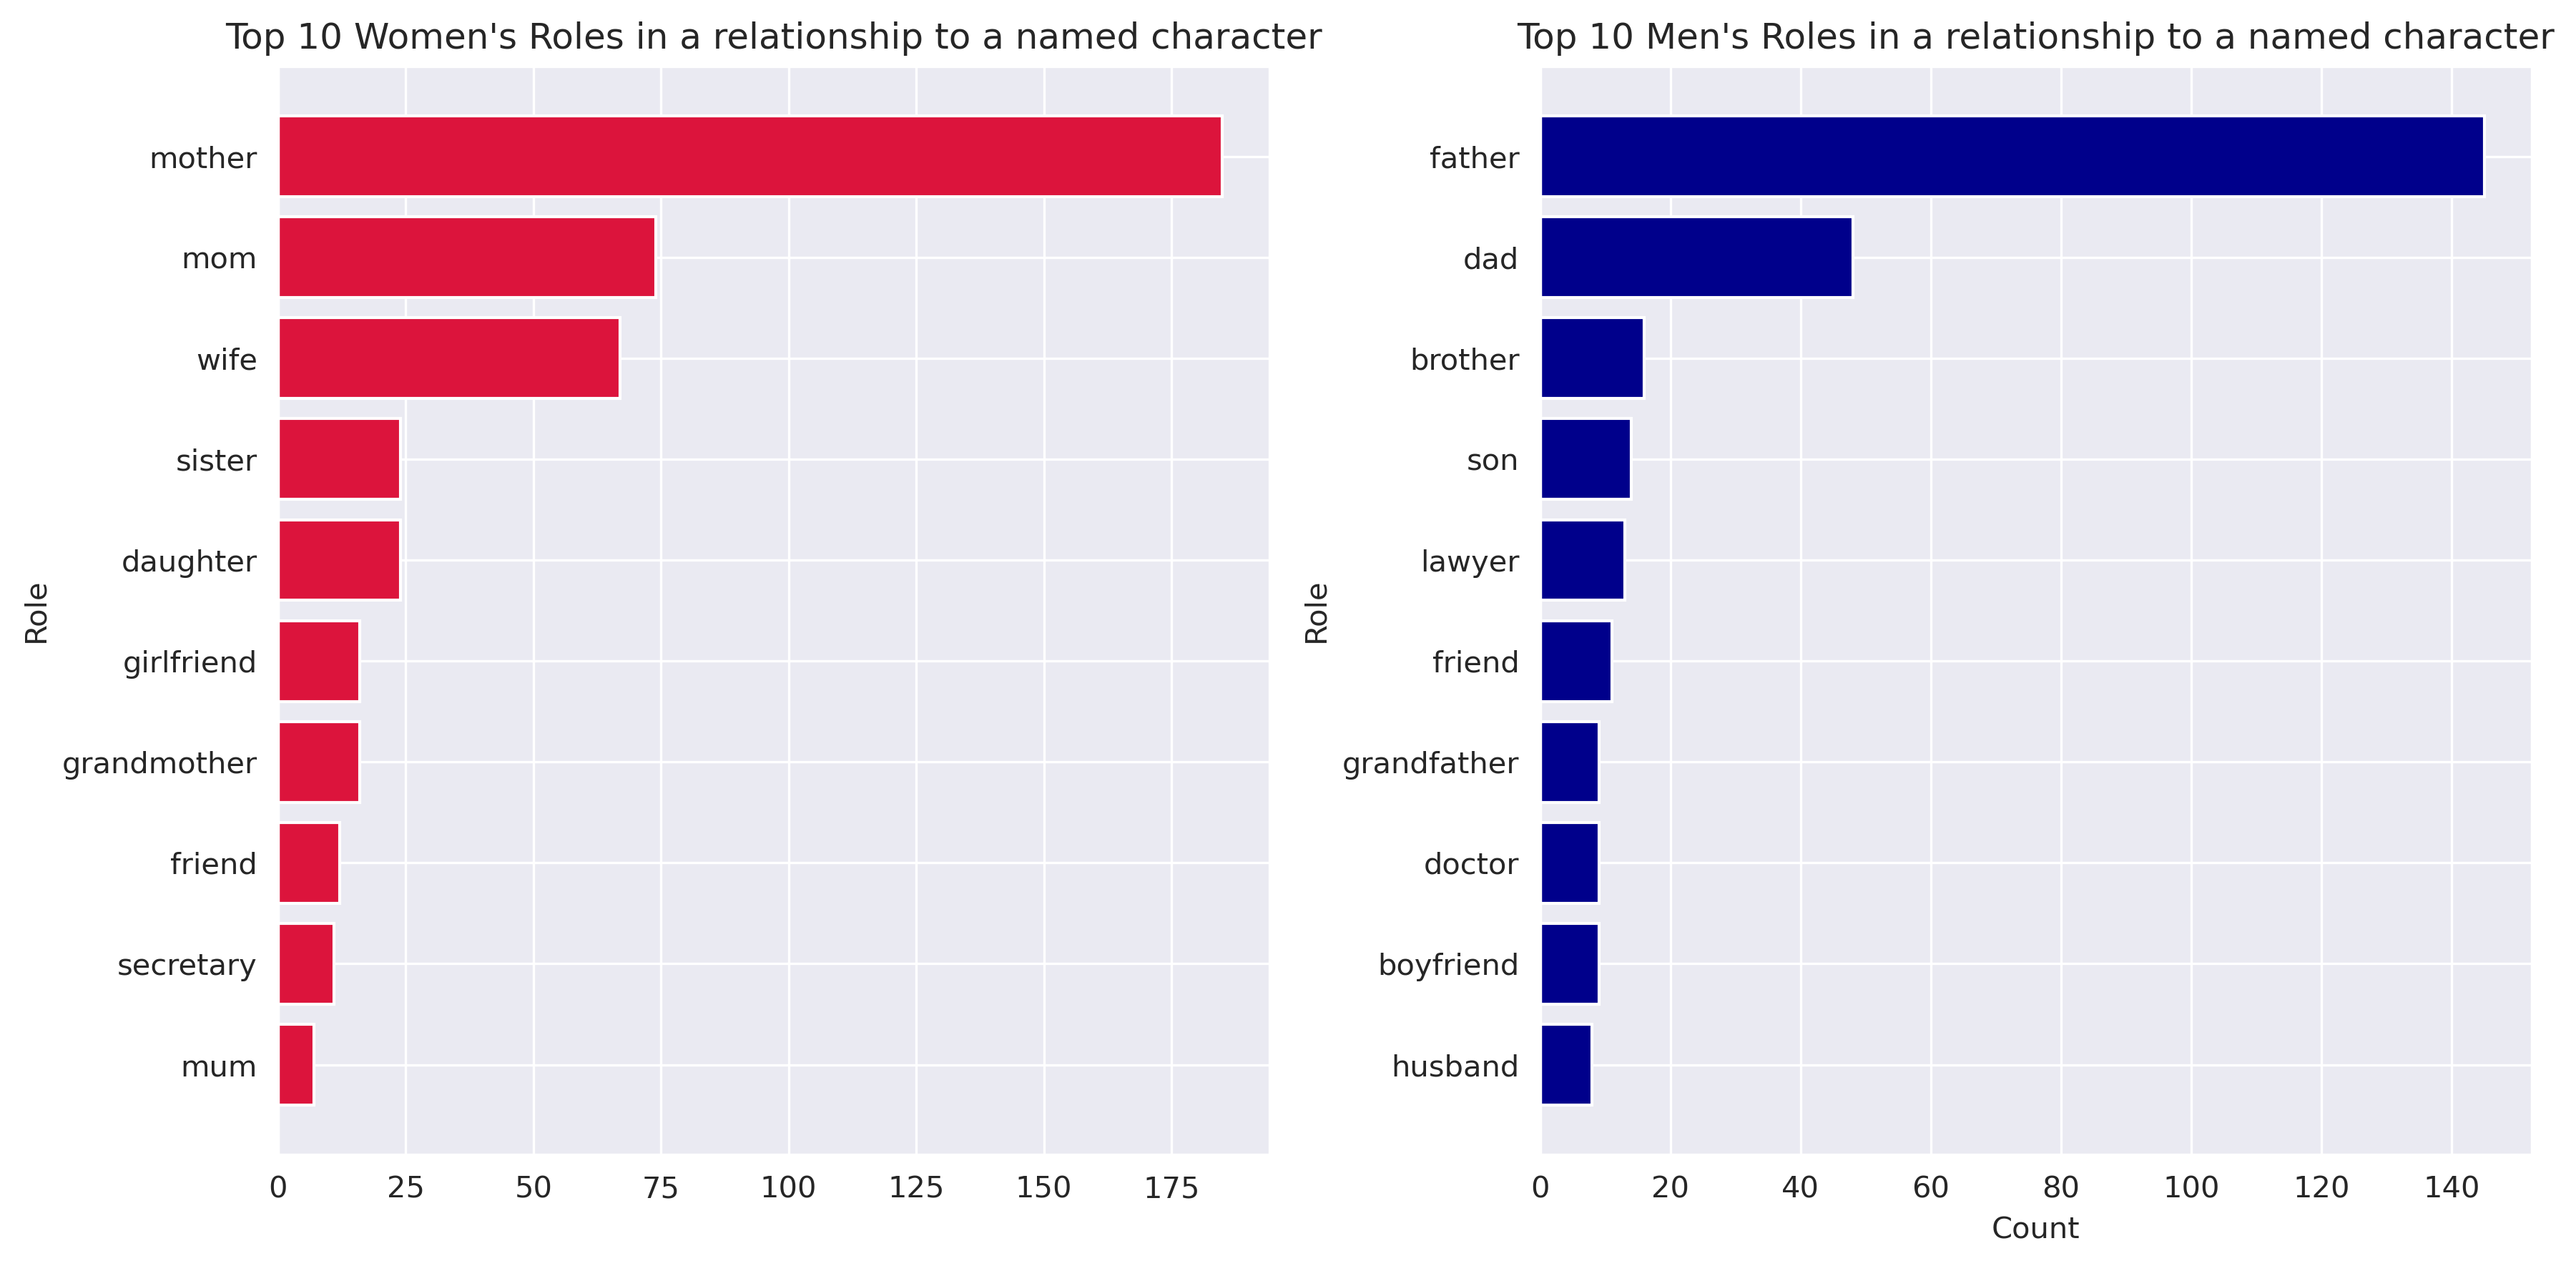

In [66]:
viz.visualize_barplot_r2n_roles(movies_with_roles_cat)
viz.visualize_barplot_r2n_roles_HTML(movies_with_roles_cat)

We see similar roles, unsurprisingly, most of them are family members with a named character but for the roles that are not, we notice again that they include lawyer and doctor for actor's role and secretary for the women's role...

We will not look at the supporting roles credited as in a relationship with a person characterized by their job, as they represent too few examples.

So, what did we find ?

In summary, the contrast in the roles given to actors and actresses reflect common gender stereotypes in storytelling and media, where men are often associated with higher social status jobs, power, authority and action, while women are often portrayed in relation to helpful and emotional roles, when they are not their personal assistant.

This is a useful piece of the puzzle on how stereotypes are conveyed in movies productions.


### Part 3. Analysis of reception 
### Part 4. Across the world (Fine-Grained Analysis)

## 2.2. Bechdel Test 

This section seeks to ascertain whether the Bechdel test can function as a substantive gauge for assessing the depiction of women in films, transcending its elementary criteria. Despite the complexity of this query, the Bechdel test presents itself as a compelling subject for examination.

In [ ]:
movies_with_bechdel = pd.read_pickle("./data/Processed/movies_with_bechdel.pkl")
movies_with_bechdel = movies_with_bechdel.drop_duplicates(subset=['movie_title'])
movies_with_bechdel = movies_with_bechdel.dropna(subset=['bechdel_rating'])
nb_movies = movies_with_bechdel['movie_title'].nunique()
print("We are working with {} movies.".format(nb_movies))

We are working with 2658 movies.


The dataset we are working with comprises 2,658 films which is an adequate size for conducting preliminary analyses.

### 2.2.1. Does passing the Bechdel test imply that more women are involved ?

In [156]:
# Load the dataset
from analysis import bechdel 
file_path = './data/MovieSummaries/character.metadata.tsv'
data = pd.read_csv(file_path, sep='\t', header=None)
data = bechdel.get_number_of_actors(data)

In [157]:
movies_with_bechdel = movies_with_bechdel.merge(data, left_on='freebaseID', right_on=1, how='left')
movies_with_bechdel = movies_with_bechdel.drop_duplicates(subset=['movie_title'])

In [158]:
movies_agg = movies_with_bechdel.groupby('bechdel_rating')[['Female_Actors_Per_Film', 'Male_Actors_Per_Film']].sum()
movies_agg['Total_Actors_Per_Film'] = movies_agg['Female_Actors_Per_Film'] + movies_agg['Male_Actors_Per_Film']
movies_agg['Female Proportion'] = movies_agg['Female_Actors_Per_Film'] / movies_agg['Total_Actors_Per_Film']
movies_agg['Male Proportion'] = movies_agg['Male_Actors_Per_Film'] / movies_agg['Total_Actors_Per_Film']

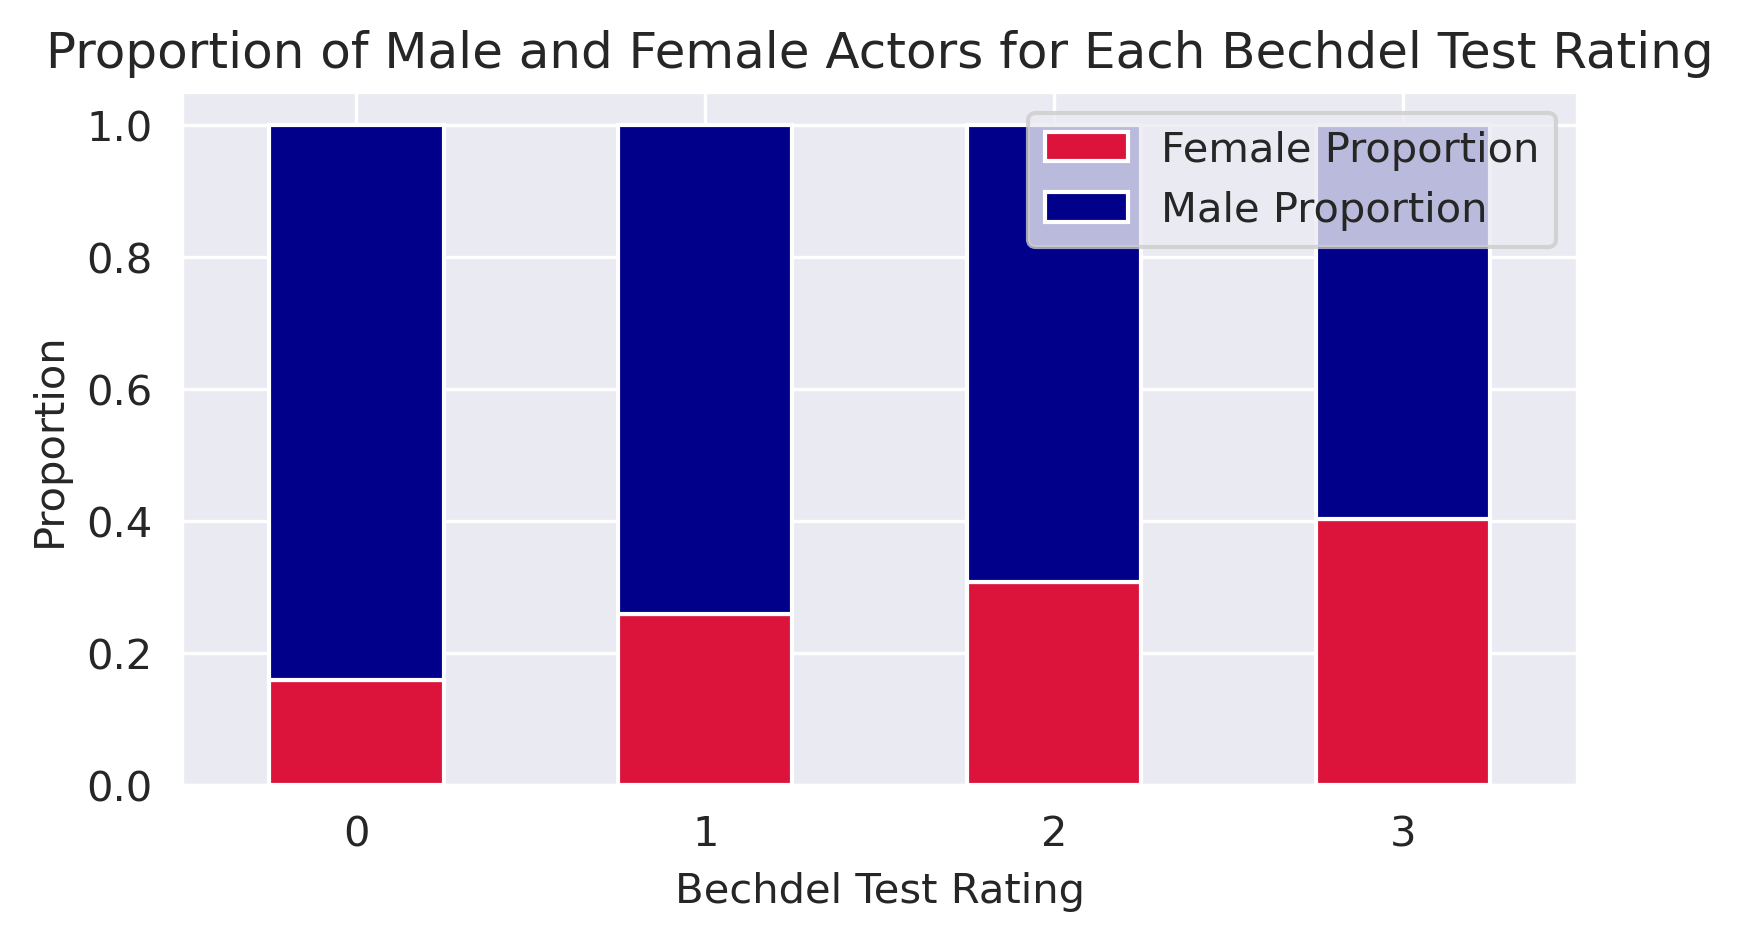

In [159]:
viz.visualize_prop_of_actor_and_bd_rating_HTML(movies_agg)
viz.visualize_prop_of_actor_and_bd_rating(movies_agg)

It is obvious that a higher Bechdel rating typically indicates a greater representation of women (>20% increase for movies which completely pass the Bechdel test compared to the ones that do not), by the test's inherent design.

### 2.2.2 Does passing the Bechdel test imply better popularity ? 

In [160]:
movies_with_bechdel.popularity = movies_with_bechdel.popularity.astype(float)
reception_bechdel = movies_with_bechdel.groupby('bechdel_rating')[['popularity', 'vote_average']].mean()

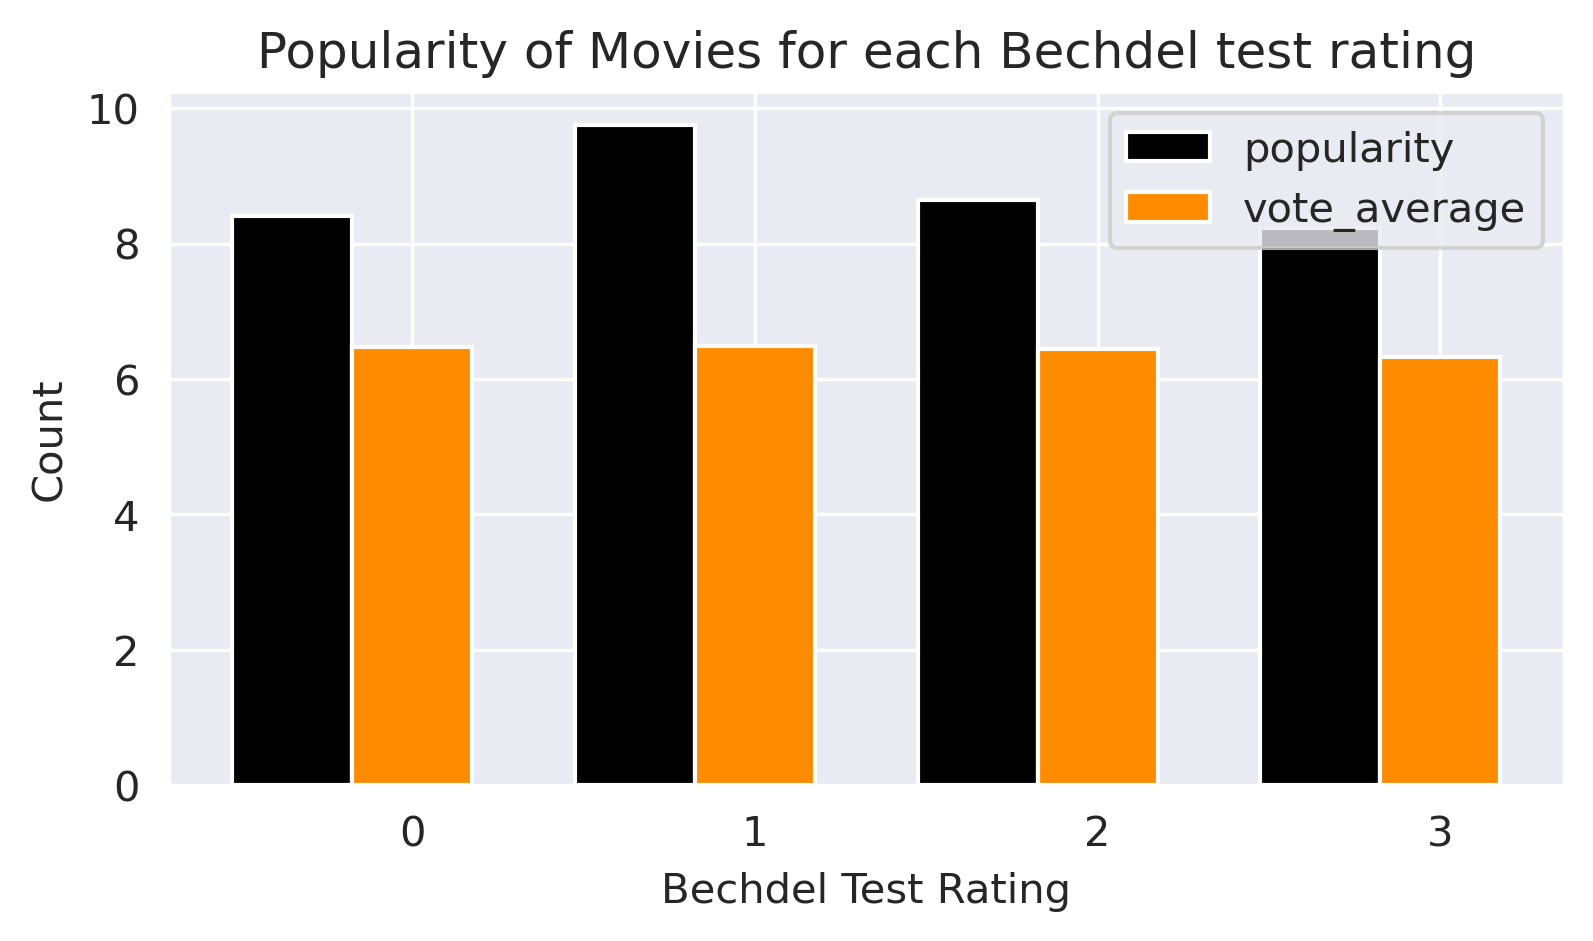

In [161]:
viz.visualize_popularity_HTML(reception_bechdel)
viz.visualize_popularity(reception_bechdel)

Observations suggest that movies with a lower Bechdel Rating often enjoy greater popularity. Pinpointing the exact reasons for this trend is challenging due to numerous potential confounding factors. It's possible that the film industry prioritizes promoting movies that predominantly feature male characters, or audiences may naturally gravitate towards films with a significant male presence. 

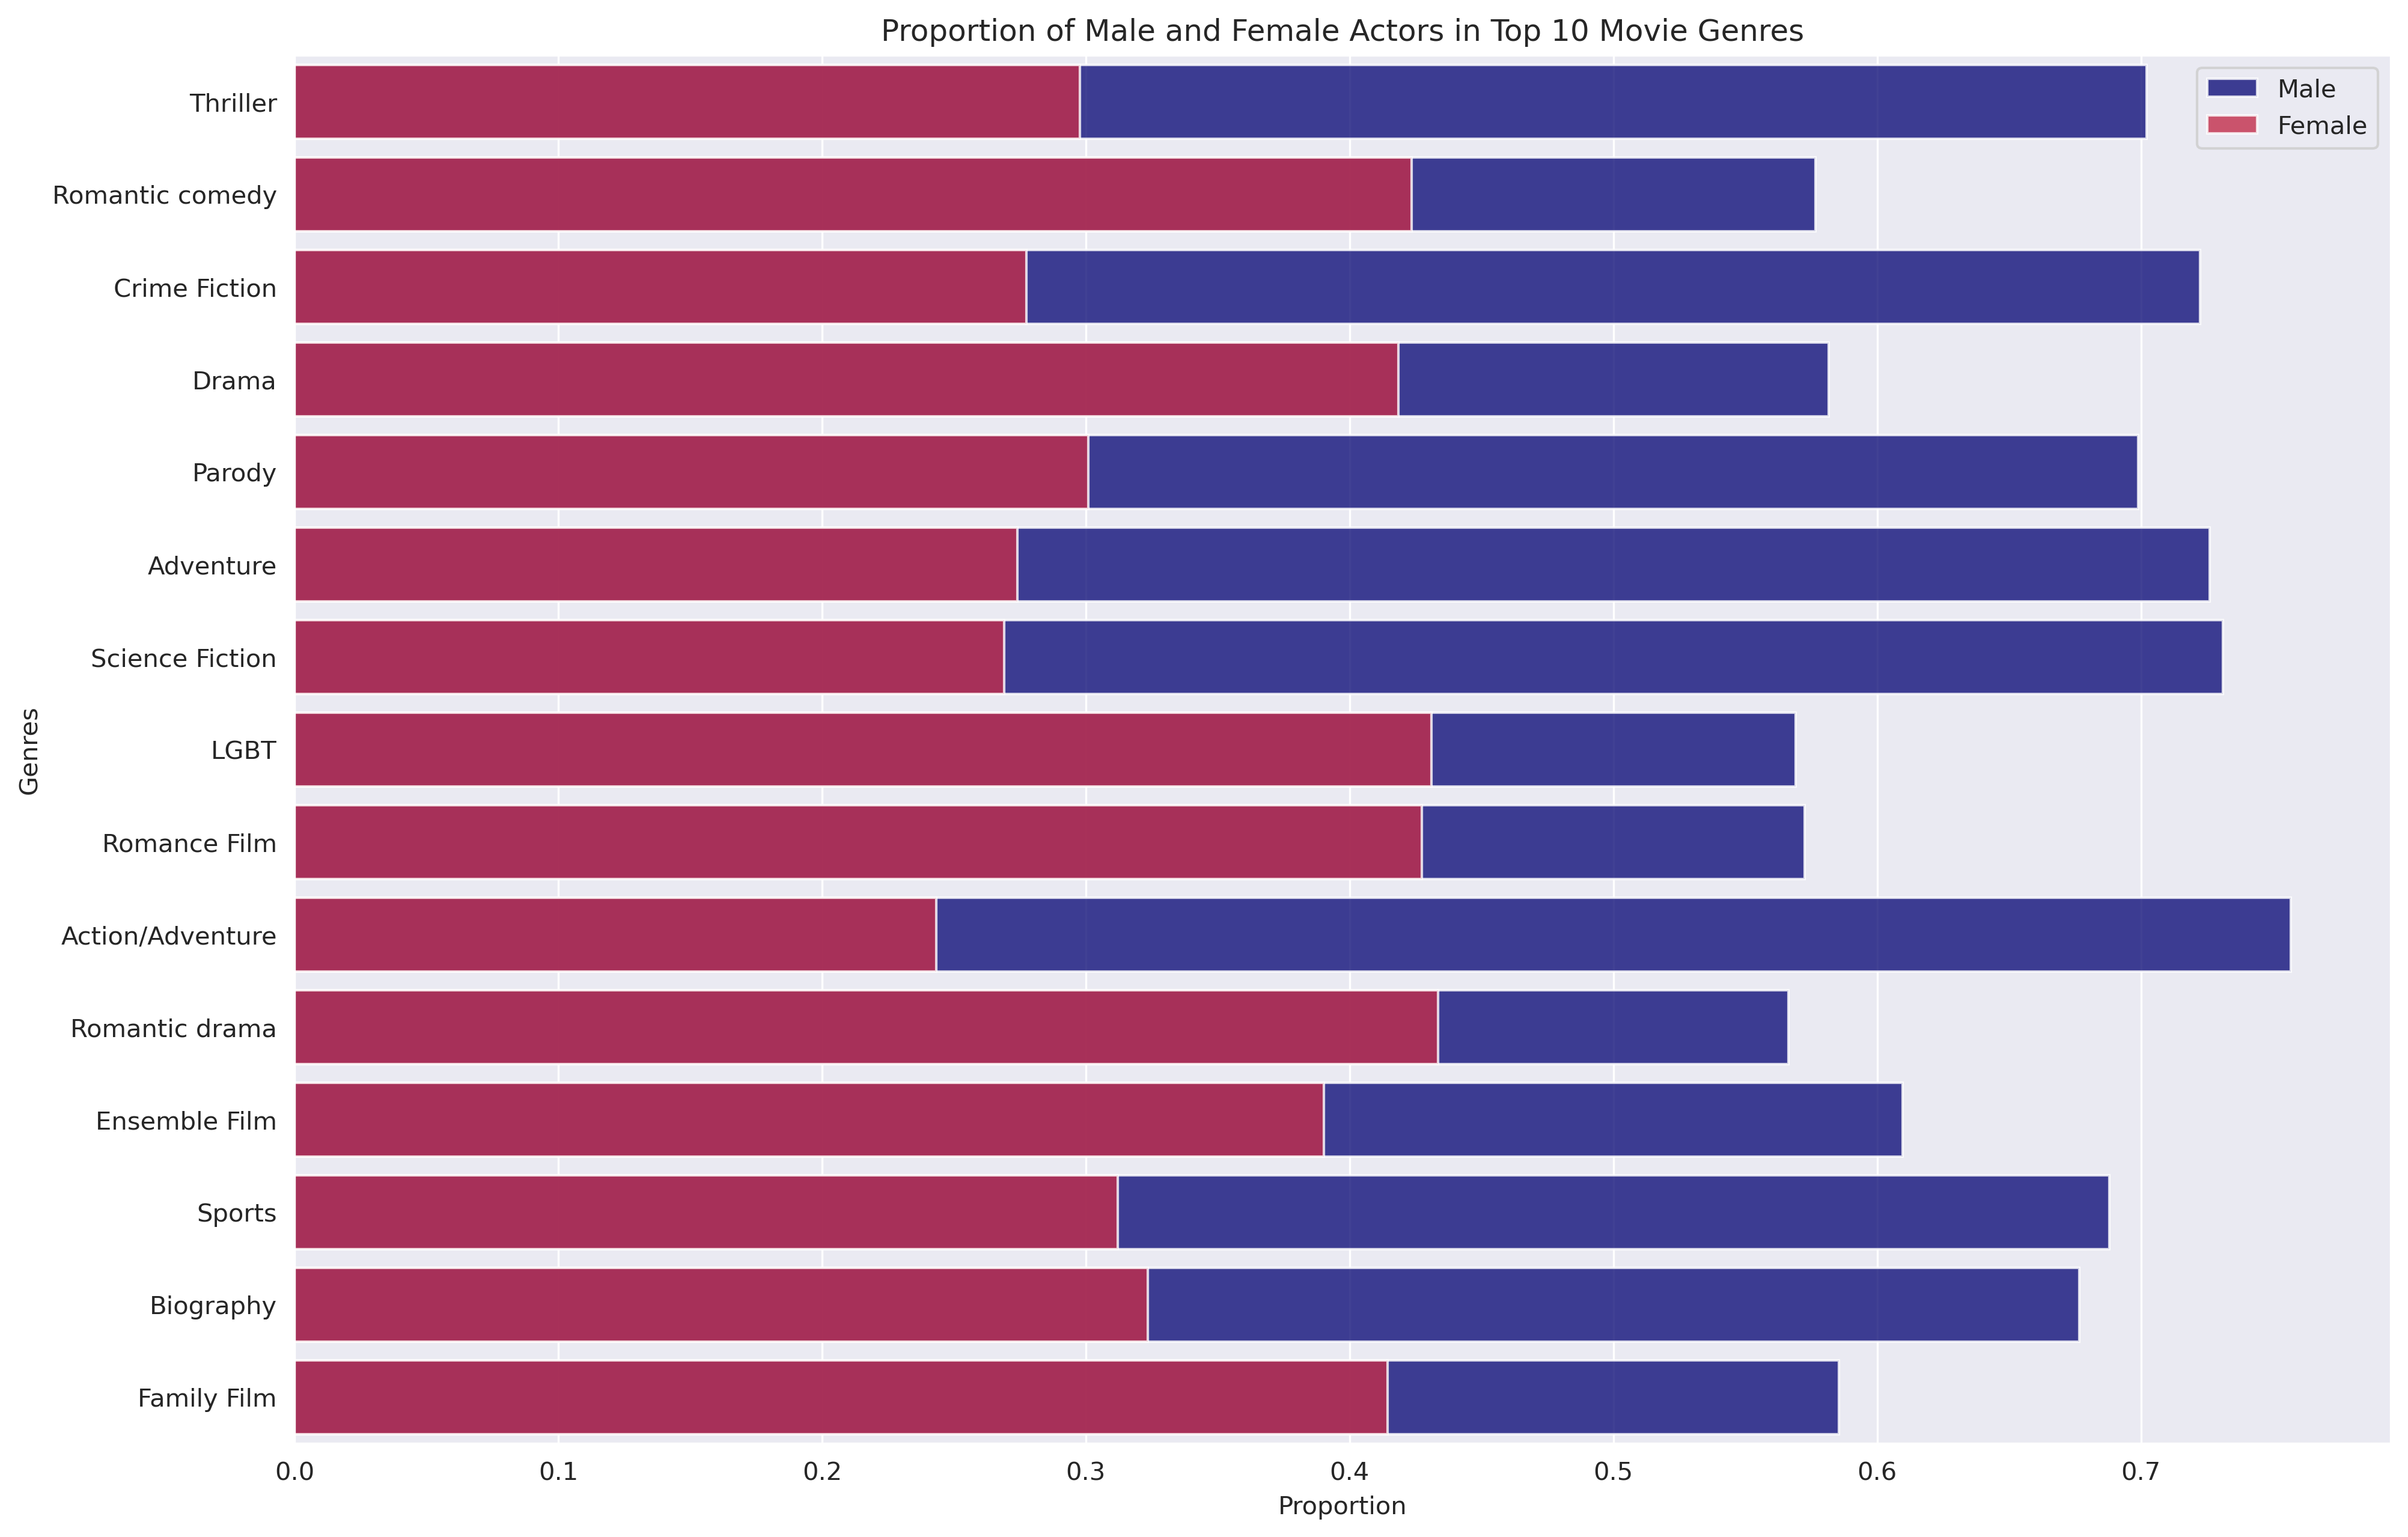

In [162]:
movies_with_bechdel['main_genre'] = movies_with_bechdel['fbid_genres'].apply(lambda x: x[0] if x else None)
movies_with_bechdel = movies_with_bechdel.dropna(subset=['main_genre']) 

# Group by genre and compare the proportion of male/female in each genre
genres_data = movies_with_bechdel.groupby('main_genre').agg(
    Total_Male_Actors=('Male_Actors_Per_Film', 'sum'),
    Total_Female_Actors=('Female_Actors_Per_Film', 'sum')
).reset_index()

genres_data['Total_Actors'] = genres_data['Total_Male_Actors'] + genres_data['Total_Female_Actors']

# Calculating proportions
genres_data['Proportion_Male'] = genres_data['Total_Male_Actors'] / genres_data['Total_Actors']
genres_data['Proportion_Female'] = genres_data['Total_Female_Actors'] / genres_data['Total_Actors']
genres_data = genres_data.sort_values(by='Total_Actors', ascending=False)

# Visualization
viz.visualize_genres_dist_on_bd_HTML(genres_data)
viz.visualize_genres_dist_on_bd(genres_data)

The distribution of male and female actors varies significantly across movie genres. Female actors are more frequently seen in LGBT, Drama, and Romance films, whereas they are less prevalent in Action or Crime movies. It could be a could idea to match movies on genre to eliminate this disparity.

#### Matching on genre

To investigate whether a movie's genre influences its Bechdel Rating and popularity, we can employ the exact one-to-one matching on genre. This approach involves pairing movies based on their genre, ensuring that each pair consists of films from the same genre. By comparing movies within these genre-matched pairs, we can more accurately assess the impact of genre on both Bechdel Ratings and audience popularity. This controlled comparison helps isolate the variable of genre, allowing for a clearer understanding of its role. 

- **Treatment Group**: Movies from a genre that typically scores high on the Bechdel test.
- **Control Group**: Movies from a genre that typically scores low on the Bechdel test.

In [163]:
movies_with_bechdel['main_genre'] = movies_with_bechdel['fbid_genres'].apply(lambda x: x[0] if x else None)

low = movies_with_bechdel[movies_with_bechdel['bechdel_rating'] <= 1]
high = movies_with_bechdel[movies_with_bechdel['bechdel_rating'] >= 2]
matched = pd.DataFrame(columns=['genre', 'control', 'treatment', 'control_rating', 'control_popularity', 'treatment_rating', 'treatment_popularity'])

for index1, row1, in low.iterrows(): 
    for index2, row2, in high.iterrows(): 
        if row1['main_genre'] == row2['main_genre']:
             # Add the row to the match dataframe
            matched.loc[len(matched)] = {
                "genre": row1["main_genre"],
                "treatment": row1["movie_title"],
                "control": row2["movie_title"],
                "control_rating": row1["bechdel_rating"],
                "control_popularity": row1["popularity"],
                "treatment_rating": row2["bechdel_rating"],
                "treatment_popularity": row2["popularity"],
            }

            # Drop the rows to not match them again
            low = low.drop(index1)
            high = high.drop(index2)
            break

display(matched.sample(2))
print("We have matched {} movies.".format(len(matched)))

,genre,control,treatment,control_rating,control_popularity,treatment_rating,treatment_popularity
672,LGBT,I Like It Like That,Deliverance,1,8.476681,3,0.289295
89,Romantic drama,Lolita,One Day,1,11.239012,3,9.551293


We have matched 880 movies.


Now, let's try to estimate the following linear regression `popularity ~ bechdel_rating`

In [164]:
import statsmodels.formula.api as smf
matched_movies = pd.concat(
    [
        movies_with_bechdel[movies_with_bechdel["movie_title"].isin(matched["treatment"])],
        movies_with_bechdel[movies_with_bechdel["movie_title"].isin(matched["control"])],
    ]
)

regression_model = smf.ols("popularity ~ bechdel_rating", data=matched_movies).fit()
print(regression_model.summary())

                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5708
Date:                Thu, 21 Dec 2023   Prob (F-statistic):              0.450
Time:                        21:52:31   Log-Likelihood:                -5927.6
No. Observations:                1760   AIC:                         1.186e+04
Df Residuals:                    1758   BIC:                         1.187e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          9.4003      0.316     29.

The $p$-value corresponding to the `bechdel_rating` coefficient is notably higher than the conventional significance threshold of $0.05$, meaning that it is not statistically significant.

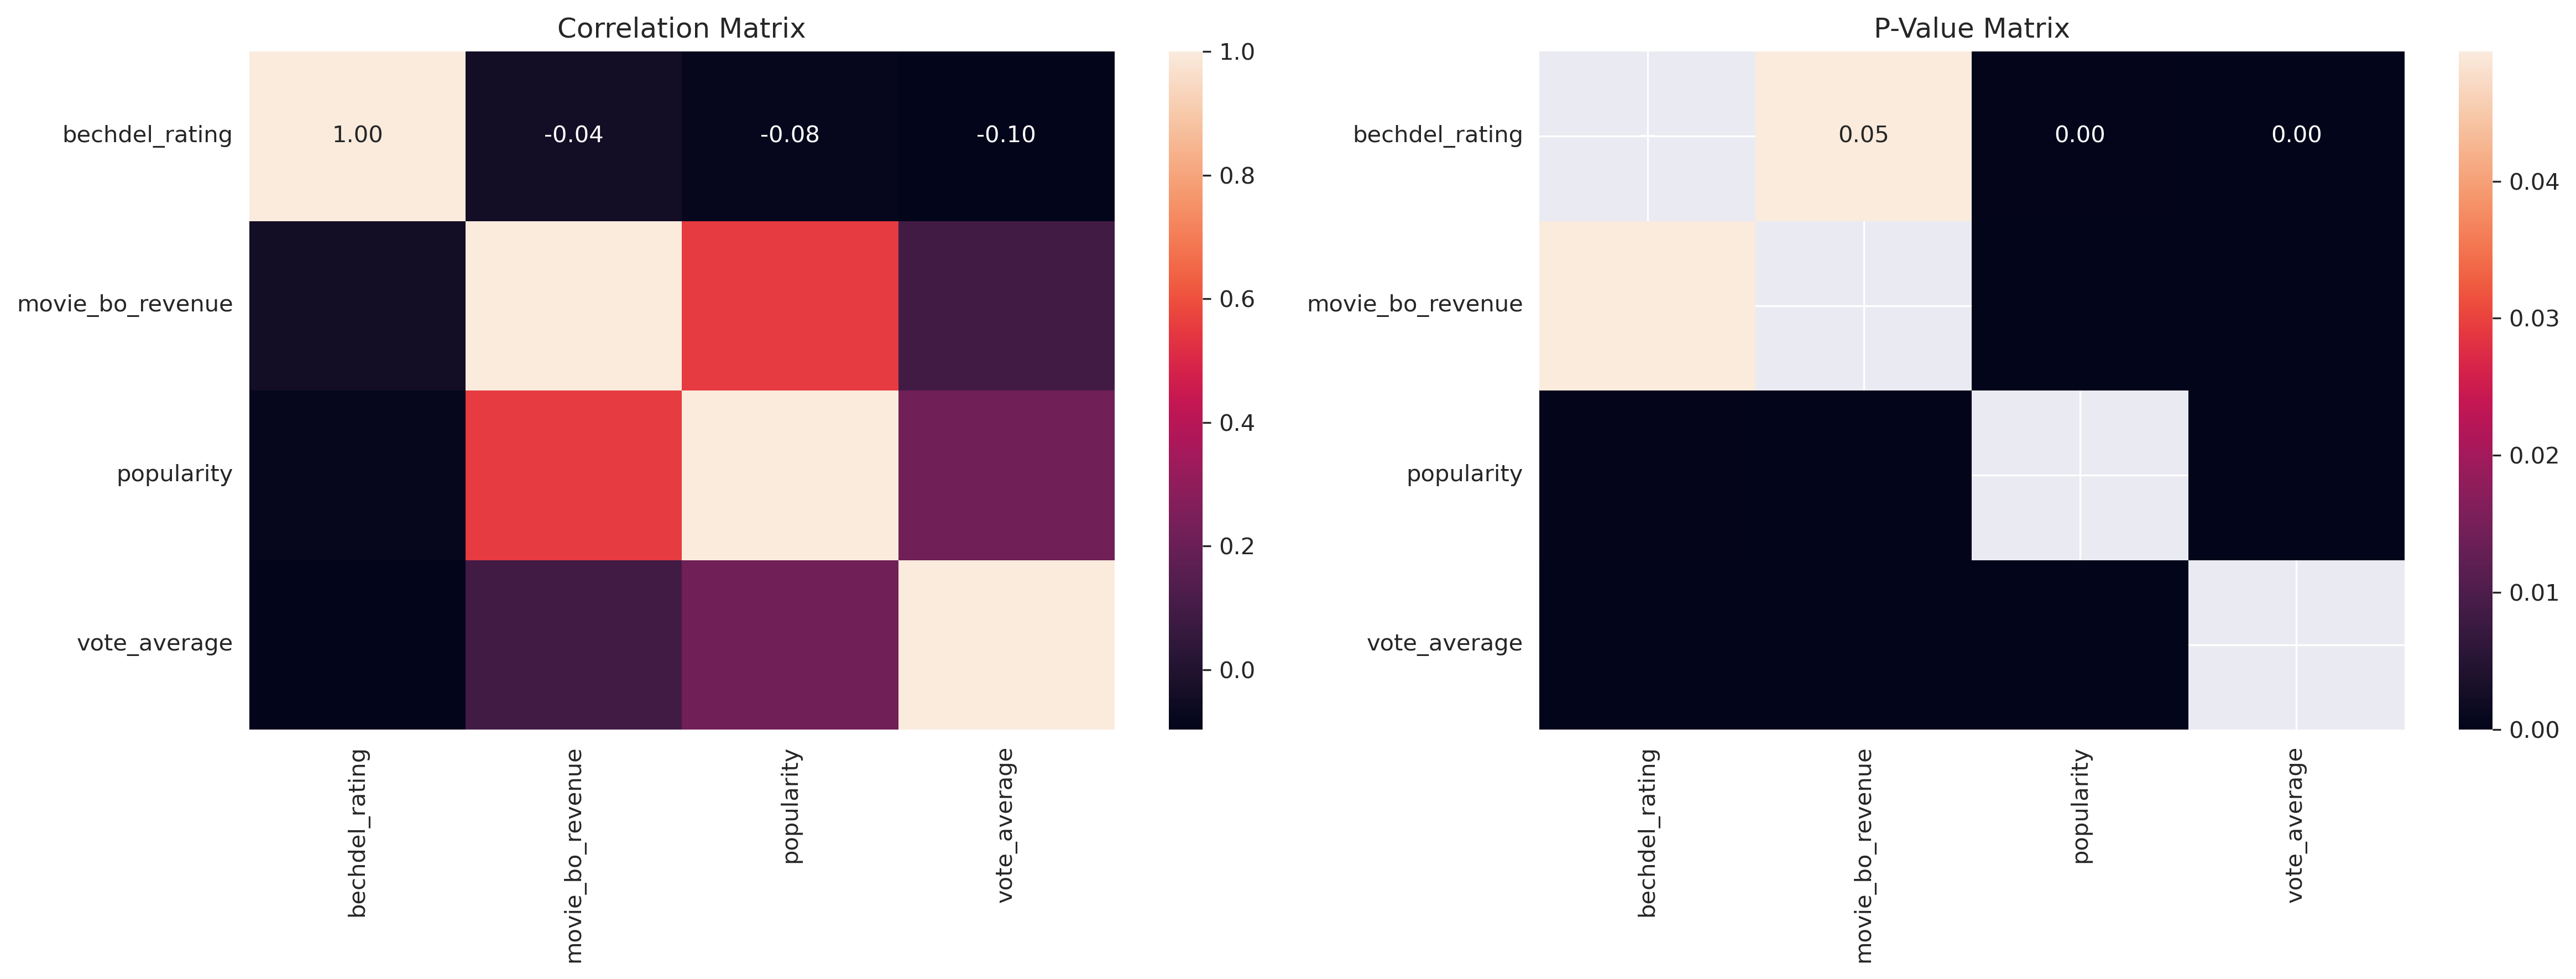

In [165]:
analysis_data = movies_with_bechdel.dropna(subset=['bechdel_rating', 'movie_bo_revenue', 'popularity', 'vote_average', 'movie_runtime'])
correlation_matrix = analysis_data[['bechdel_rating', 'movie_bo_revenue', 'popularity', 'vote_average']].corr()
p_values = pd.DataFrame(index=correlation_matrix.columns, columns=correlation_matrix.columns)

for row in correlation_matrix.columns:
    for col in correlation_matrix.columns:
        if row != col:
            corr_test = pearsonr(analysis_data[row], analysis_data[col])
            p_values[row][col] = corr_test[1]
        else:
            p_values[row][col] = np.nan

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="rocket", ax=ax[0])
ax[0].set_title('Correlation Matrix')

sns.heatmap(p_values.astype(float), annot=True, fmt=".2f", cmap="rocket", ax=ax[1])
ax[1].set_title('P-Value Matrix')

plt.tight_layout()
plt.show()

This heatmap on the left graphically represents the correlation coefficients among various variables: Bechdel test ratings, box office revenue, popularity, and average movie ratings. The other heatmap on the right represents the $p$-value associate with the correlation coefficients. They are all small (between $0.00$ and $0.05$) meaning that the left-heatmap is statistically significant. For the left heatmap, these coefficients are quantified on a scale extending from -1 to 1, where -1 denotes a perfectly inverse correlation, 0 signifies no correlation, and 1 indicates a perfectly direct correlation. It is observed that the correlations are generally weak, implying that the Bechdel test ratings possess a minimal direct influence on both the financial success at the box office and the general public's acceptance of films.

This suggests that the Bechdel test results do not demonstrate a statistically significant impact in this context. This implies that movie producers may not find a compelling reason to enhance the Bechdel rating of their films, as it appears to have no significant impact on audience reception.

### 2.2.3. How the Bechdel Rating has evolved through time ?

In [166]:
movies_with_bechdel["movie_release_date"] = pd.to_datetime(
        movies_with_bechdel["movie_release_date"], errors="coerce"
    )
movies_with_bechdel["release_year"] = movies_with_bechdel["movie_release_date"].dt.year

filtered_data = movies_with_bechdel.dropna(subset=["release_year", "bechdel_rating"])

yearly_bechdel = (
    filtered_data.groupby(["release_year", "bechdel_rating"])
    .size()
    .unstack(fill_value=0)
)

yearly_bechdel["total_movies"] = yearly_bechdel.sum(axis=1)

yearly_bechdel = yearly_bechdel[yearly_bechdel["total_movies"] > 15]
yearly_bechdel["proportion_passing"] = (yearly_bechdel[3] / yearly_bechdel["total_movies"])

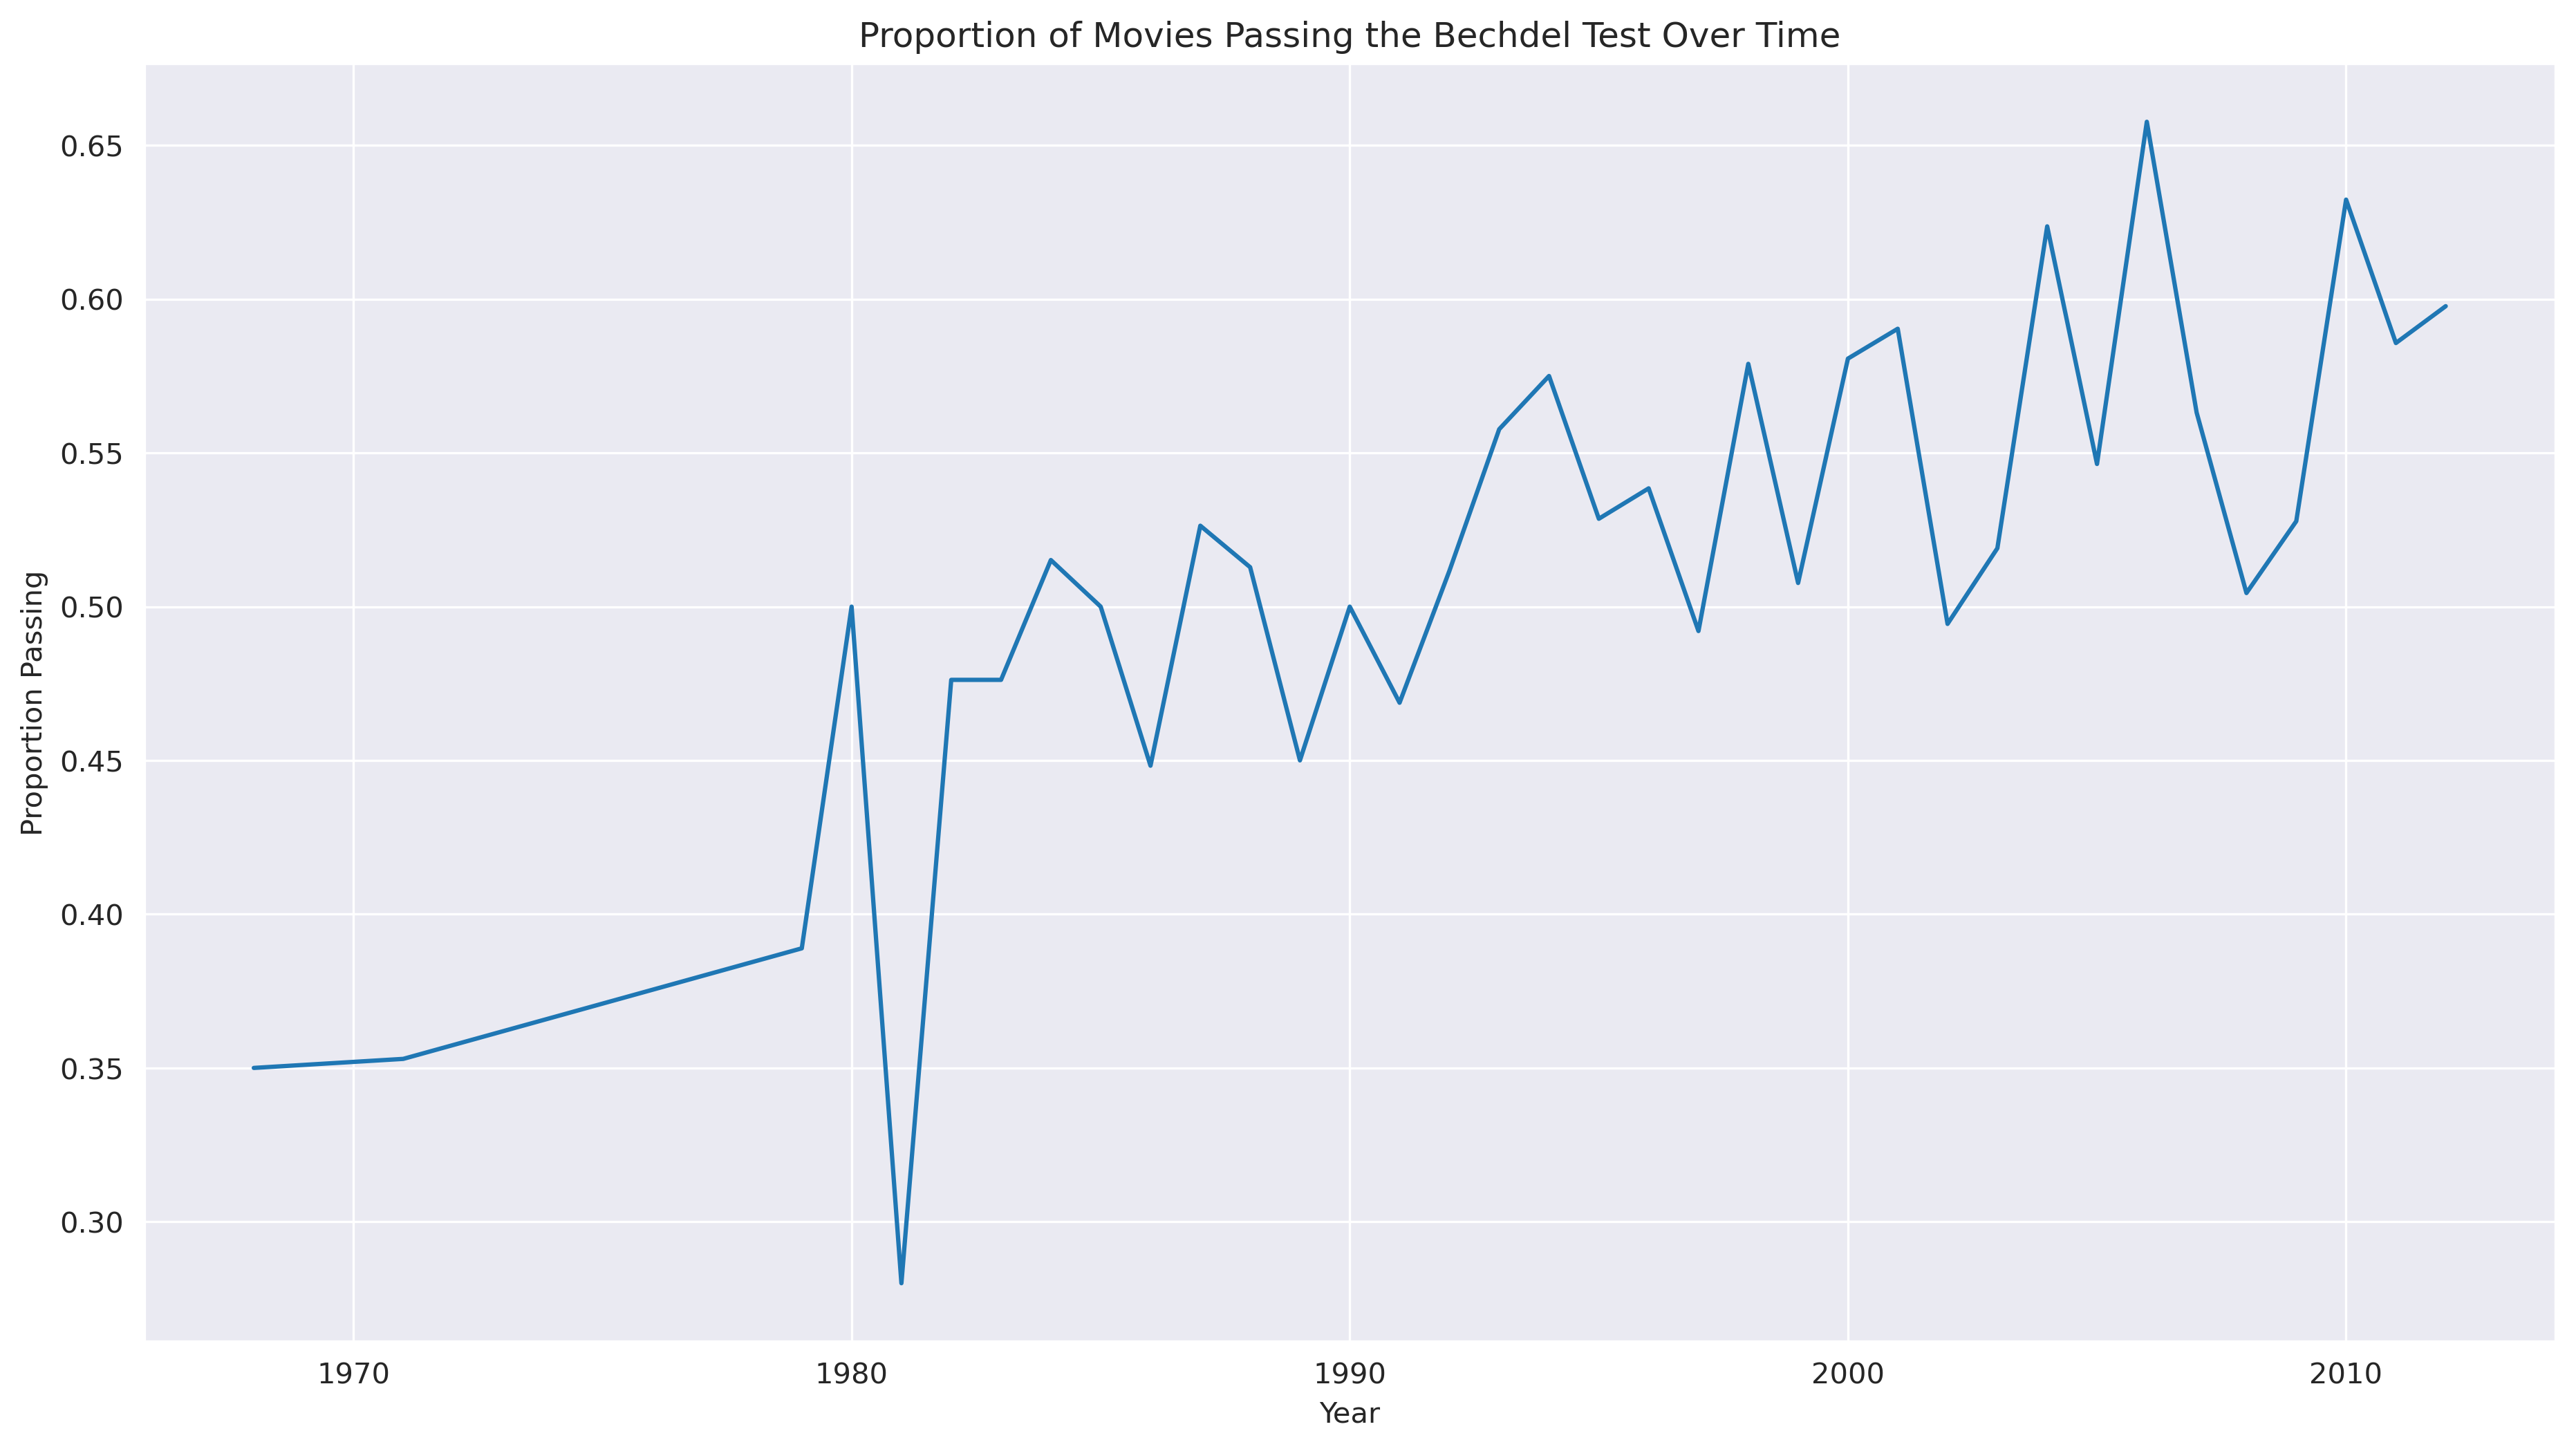

In [167]:
viz.visualize_bd_rating_evolution_HTML(yearly_bechdel, year_range=YEAR_RANGE)
viz.visualize_bd_rating_evolution(yearly_bechdel)

The trend line offers insights into how the representation of women in films, as measured by the Bechdel test, has evolved in years with a significant number of movies. But, it's possible that the apparent increase in the proportion of movies passing the Bechdel test over time could be influenced by the overall growth in the number of movies produced each year. If the film industry is producing more movies overall, this could naturally lead to an increase in the number of films passing the Bechdel test, even if the proportion of films that are gender-inclusive doesn't change significantly, which is actually the case as depicted below: 

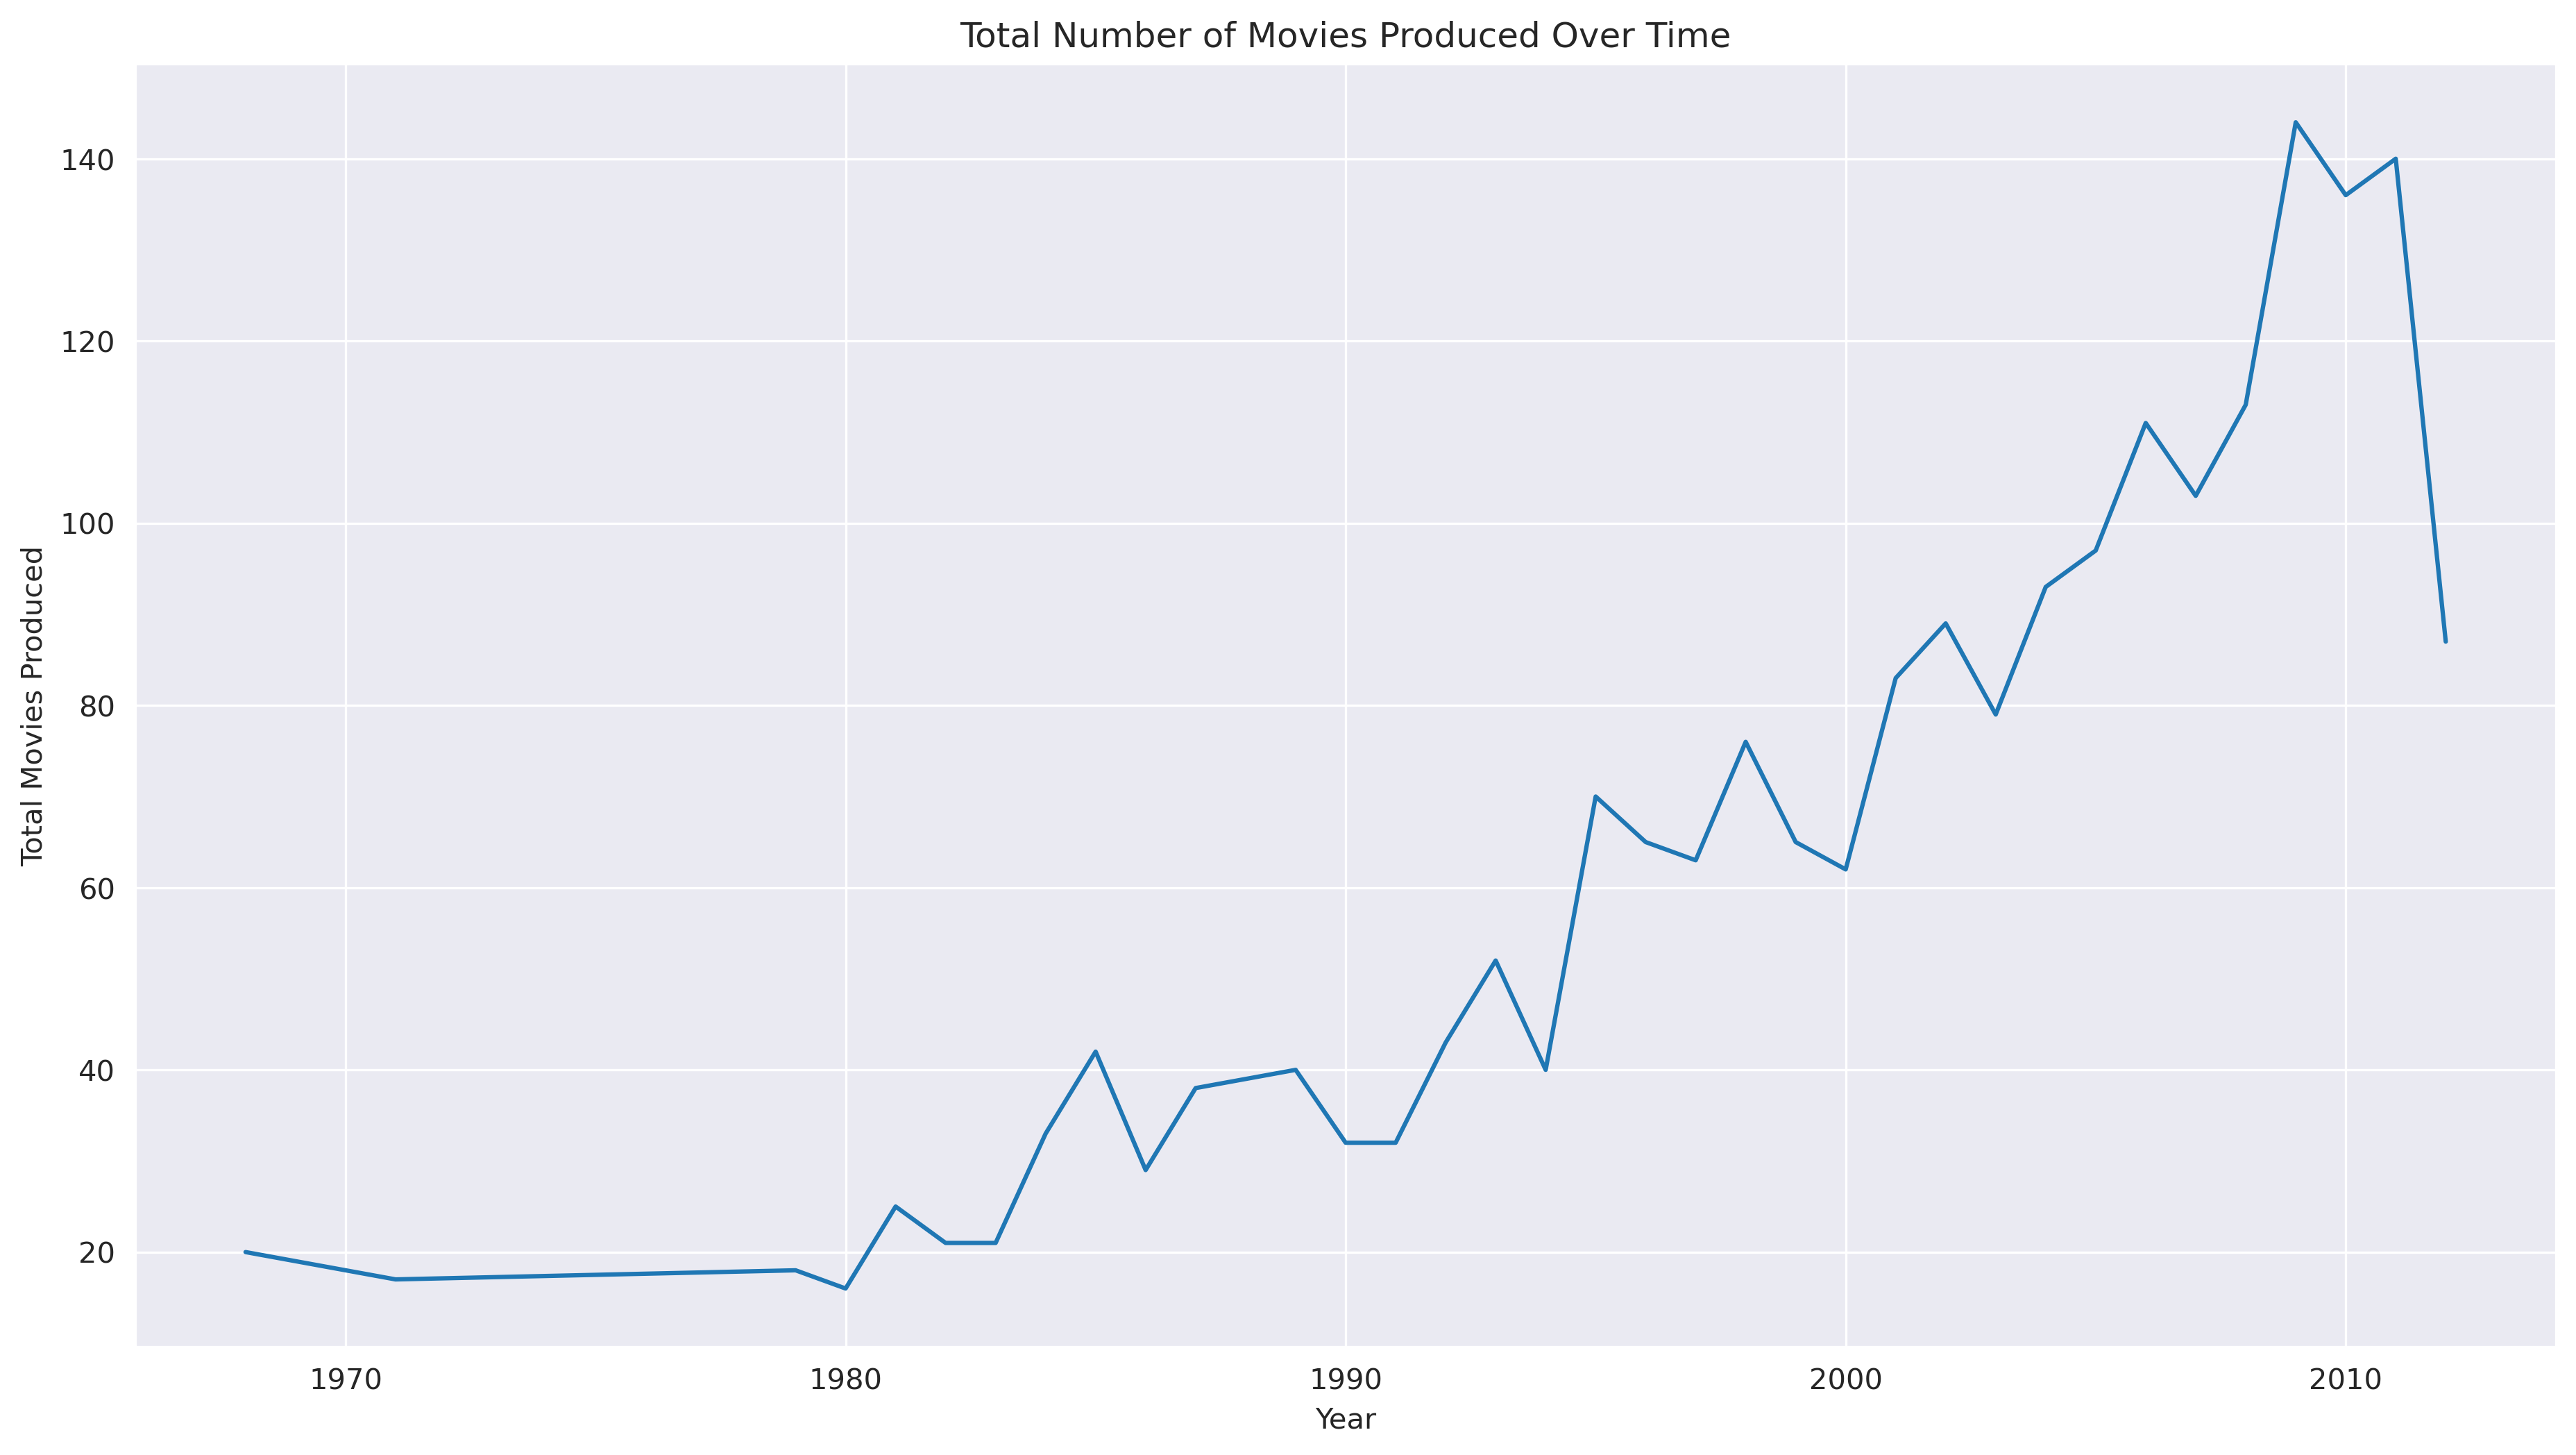

In [168]:
viz.visualize_number_of_movies_HTML(yearly_bechdel, year_range=YEAR_RANGE)
viz.visualize_number_of_movies(yearly_bechdel)

### Conclusion

In conclusion, while the Bechdel test can be a useful initial indicator of female presence in films, it is not a comprehensive measure of a film's portrayal of women. 

The test's simplicity means it can highlight certain aspects of gender representation but does not assess the depth or quality of female characters and their narratives. 

In recent years, there has been a noticeable uptrend in the number of films passing the Bechdel test. This phenomenon can be attributed primarily to the overall rise in the volume of film production. Despite this trend, the Bechdel test does not currently serve as a key objective for film producers and directors. Its results have shown no significant correlation with a movie's financial success or its popularity among audiences.

Although the Bechdel test serves as a rudimentary gauge of gender representation in films, its simplicity limits its effectiveness. A more in-depth and nuanced analysis of gender dynamics in cinema requires the combination of the Bechdel test with a broader set of criteria and metrics. This expanded approach would offer a richer and more detailed perspective, enhancing decision-making in the filmmaking process and potentially leading to more meaningful representation in the industry.

## 2.3 NLP 


# 3. Conclusion